# Credit Risk Modeling and RAG-Enhanced Explainable Decision Support System

## 1. Introduction

This notebook develops a credit risk Probability of Default (PD) model using public LendingClub loan data. Logistic regression is used as a baseline model and compared with tree-based methods such as XGBoost. Model performance is evaluated using AUC-ROC and KS statistics, and SHAP is applied to explain key risk drivers. The objective is to support human credit assessment through transparent and interpretable modeling.

## 2. Problem Definition & Target Variable

The objective of this analysis is to predict loan default using historical LendingClub data. From a credit risk perspective, default represents a failure of the borrower to meet contractual repayment obligations.

Default is defined as loans with a status of **Charged Off** or **Default**, while loans that are **Fully Paid** are treated as non-default. Loans with ongoing or incomplete statuses are excluded to ensure a well-defined supervised learning problem, as their final repayment outcomes are not yet observed.

This target definition is consistent with standard industry practice for Probability of Default (PD) modeling, where only resolved loans are used for model training and evaluation.

## 3. Data Description


The dataset used in this analysis is sourced from **LendingClub**, a peer-to-peer lending platform based in the United States. It contains loan-level information for loans issued between 2007 and 2015, including borrower financial characteristics, credit history indicators, loan attributes, and repayment outcomes.

The original dataset is large in scale and **includes hundreds of thousands of observations and numerous variables. For the purpose of credit risk modeling, a subset of economically meaningful features is selected, focusing on borrower repayment capacity, credit behavior, utilization, and loan characteristics. This approach reflects common industry practice and helps ensure efficient and interpretable model development.

## 4. Data Preparation

The data preparation process focuses on **creating a clean and modeling-ready dataset** for credit risk analysis. Only loans with resolved outcomes are retained, where Charged Off and Default loans are treated as default events and Fully Paid loans as non-default. Loans with ongoing or incomplete statuses are excluded to avoid label ambiguity.

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import re
import math
import matplotlib.ticker as mtick
from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,recall_score,precision_score,f1_score,brier_score_loss
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV,calibration_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap

import warnings
import logging
for m in ["sklearn", "shap", "matplotlib"]:
    warnings.filterwarnings("ignore", module=m)

logging.getLogger("matplotlib").setLevel(logging.ERROR)

import joblib

In [6]:
pd.options.display.max_columns = None

In [7]:
status= pd.read_excel(r"C:\Users\USER\Desktop\data set\lending club data set\LCDataDictionary.xlsx")
status.head(135)

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...
...,...,...
130,hardship_reason,Describes the reason the hardship plan was off...
131,hardship_status,"Describes if the hardship plan is active, pend..."
132,deferral_term,Amount of months that the borrower is expected...
133,hardship_amount,The interest payment that the borrower has com...


In [8]:
use_cols = [
    # target
    "loan_status",

    # borrower capacity
    "annual_inc", "dti", "installment", "emp_length",
    "home_ownership", "application_type",

    # credit history (fico proxies)
    "earliest_cr_line", "delinq_2yrs", "acc_now_delinq",
    "mths_since_last_delinq", "num_accts_ever_120_pd",
    "pub_rec", "pub_rec_bankruptcies", "tax_liens",

    # utilization & balances
    "revol_util", "all_util", "bc_util", "revol_bal",
    "total_bal_ex_mort", "total_rev_hi_lim", "avg_cur_bal",

    # credit activity
    "inq_last_6mths", "inq_last_12m",
    "acc_open_past_24mths", "open_acc_6m",
    "num_tl_op_past_12m",

    # loan characteristics
    "loan_amnt", "term", "int_rate", "purpose",

    # verification
    "verification_status"
]

loan = pd.read_csv(r"C:\Users\USER\Desktop\data set\lending club data set\loan.csv", usecols=use_cols,
    low_memory=False)
loan.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,pub_rec,revol_bal,revol_util,application_type,acc_now_delinq,open_acc_6m,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_util,num_accts_ever_120_pd,num_tl_op_past_12m,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort
0,2500,36 months,13.56,84.92,10+ years,RENT,55000.0,Not Verified,Current,debt_consolidation,18.24,0.0,Apr-2001,1.0,NaN,1.0,4341,10.3,Individual,0.0,2.0,28.0,42000.0,2.0,9.0,1878.0,5.9,0.0,3.0,1.0,0.0,16901.0
1,30000,60 months,18.94,777.23,10+ years,MORTGAGE,90000.0,Source Verified,Current,debt_consolidation,26.52,0.0,Jun-1987,0.0,71.0,1.0,12315,24.2,Individual,0.0,4.0,57.0,50800.0,2.0,10.0,24763.0,8.3,0.0,6.0,1.0,0.0,99468.0
2,5000,36 months,17.97,180.69,6 years,MORTGAGE,59280.0,Source Verified,Current,debt_consolidation,10.51,0.0,Apr-2011,0.0,NaN,0.0,4599,19.1,Individual,0.0,0.0,35.0,24100.0,0.0,4.0,18383.0,0.0,0.0,0.0,0.0,0.0,11749.0
3,4000,36 months,18.94,146.51,10+ years,MORTGAGE,92000.0,Source Verified,Current,debt_consolidation,16.74,0.0,Feb-2006,0.0,NaN,0.0,5468,78.1,Individual,0.0,1.0,70.0,7000.0,3.0,5.0,30505.0,75.2,0.0,3.0,0.0,0.0,36151.0
4,30000,60 months,16.14,731.78,10+ years,MORTGAGE,57250.0,Not Verified,Current,debt_consolidation,26.35,0.0,Dec-2000,0.0,NaN,0.0,829,3.6,Individual,0.0,3.0,54.0,23100.0,0.0,9.0,9667.0,8.9,0.0,5.0,0.0,0.0,29674.0


In [9]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 32 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   loan_amnt               int64  
 1   term                    object 
 2   int_rate                float64
 3   installment             float64
 4   emp_length              object 
 5   home_ownership          object 
 6   annual_inc              float64
 7   verification_status     object 
 8   loan_status             object 
 9   purpose                 object 
 10  dti                     float64
 11  delinq_2yrs             float64
 12  earliest_cr_line        object 
 13  inq_last_6mths          float64
 14  mths_since_last_delinq  float64
 15  pub_rec                 float64
 16  revol_bal               int64  
 17  revol_util              float64
 18  application_type        object 
 19  acc_now_delinq          float64
 20  open_acc_6m             float64
 21  all_util                float64

In [10]:
# Convert the variable in the data
loan = loan.reset_index(drop= True)
loan['case_id'] = (loan.index+1).astype('str')
loan = loan.set_index('case_id')
loan.head()
loan['int_rate'] = loan['int_rate']/100
loan['dti'] = loan['dti']/100
loan['term']= loan['term'].str.replace(' months','').astype('int')
loan['monthly_income'] = loan['annual_inc']/12
loan['loan_to_income'] = loan['loan_amnt']/loan['annual_inc']

# Conver emp_length to int 
def parse_emp_length(x):
    if pd.isna(x):
        return None
    if x == '10+ years':
        return 10
    elif x == '< 1 year':
        return 0
    return int(x.split()[0])

loan['emp_length'] = loan['emp_length'].apply(parse_emp_length)

In [11]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2260668 entries, 1 to 2260668
Data columns (total 34 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   loan_amnt               int64  
 1   term                    int32  
 2   int_rate                float64
 3   installment             float64
 4   emp_length              float64
 5   home_ownership          object 
 6   annual_inc              float64
 7   verification_status     object 
 8   loan_status             object 
 9   purpose                 object 
 10  dti                     float64
 11  delinq_2yrs             float64
 12  earliest_cr_line        object 
 13  inq_last_6mths          float64
 14  mths_since_last_delinq  float64
 15  pub_rec                 float64
 16  revol_bal               int64  
 17  revol_util              float64
 18  application_type        object 
 19  acc_now_delinq          float64
 20  open_acc_6m             float64
 21  all_util                float64
 22 

### 4.1 Define the default variable

In [12]:
loan['loan_status'].value_counts()

loan_status
Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: count, dtype: int64

In [13]:
# Identify loan staturs
uncertain_status = [
    'Current',
    'In Grace Period',
    'Late (16-30 days)',
    'Late (31-120 days)'
]

default_status = [
    'Charged Off',
    'Default',
    'Does not meet the credit policy. Status:Charged Off'
]

non_default_status = [
    'Fully Paid',
    'Does not meet the credit policy. Status:Fully Paid'
]

# Create a clean loan set excluding uncertain statuses
loan_set = loan[~loan['loan_status'].isin(uncertain_status)].copy() 

# map loan_status to binary values
loan_set['is_default'] = loan_set['loan_status'].map(
    lambda x: 1 if x in default_status else 0
)
loan_set['is_default'].value_counts(normalize=True)

is_default
0    0.799105
1    0.200895
Name: proportion, dtype: float64

This means:
- ~ 79.9% of loans are non-default
- ~ 20.1% of loans defaulted

## 5.Explantory Data Analysis
The exploratory analysis examines key financial, credit behavior, and loan characteristics to understand how they differ between defaulted and non-defaulted loans. This step helps confirm the reasonableness of the constructed target variable and informs subsequent model development.

In [14]:
print(f"The final dataset has {loan_set.shape[0]} rows and {loan_set.shape[1]} columns.")
print("\n")
print("The variable type of the data set is as below:")
print(loan_set.dtypes)

The final dataset has 1306387 rows and 35 columns.


The variable type of the data set is as below:
loan_amnt                   int64
term                        int32
int_rate                  float64
installment               float64
emp_length                float64
home_ownership             object
annual_inc                float64
verification_status        object
loan_status                object
purpose                    object
dti                       float64
delinq_2yrs               float64
earliest_cr_line           object
inq_last_6mths            float64
mths_since_last_delinq    float64
pub_rec                   float64
revol_bal                   int64
revol_util                float64
application_type           object
acc_now_delinq            float64
open_acc_6m               float64
all_util                  float64
total_rev_hi_lim          float64
inq_last_12m              float64
acc_open_past_24mths      float64
avg_cur_bal               float64
bc_util         

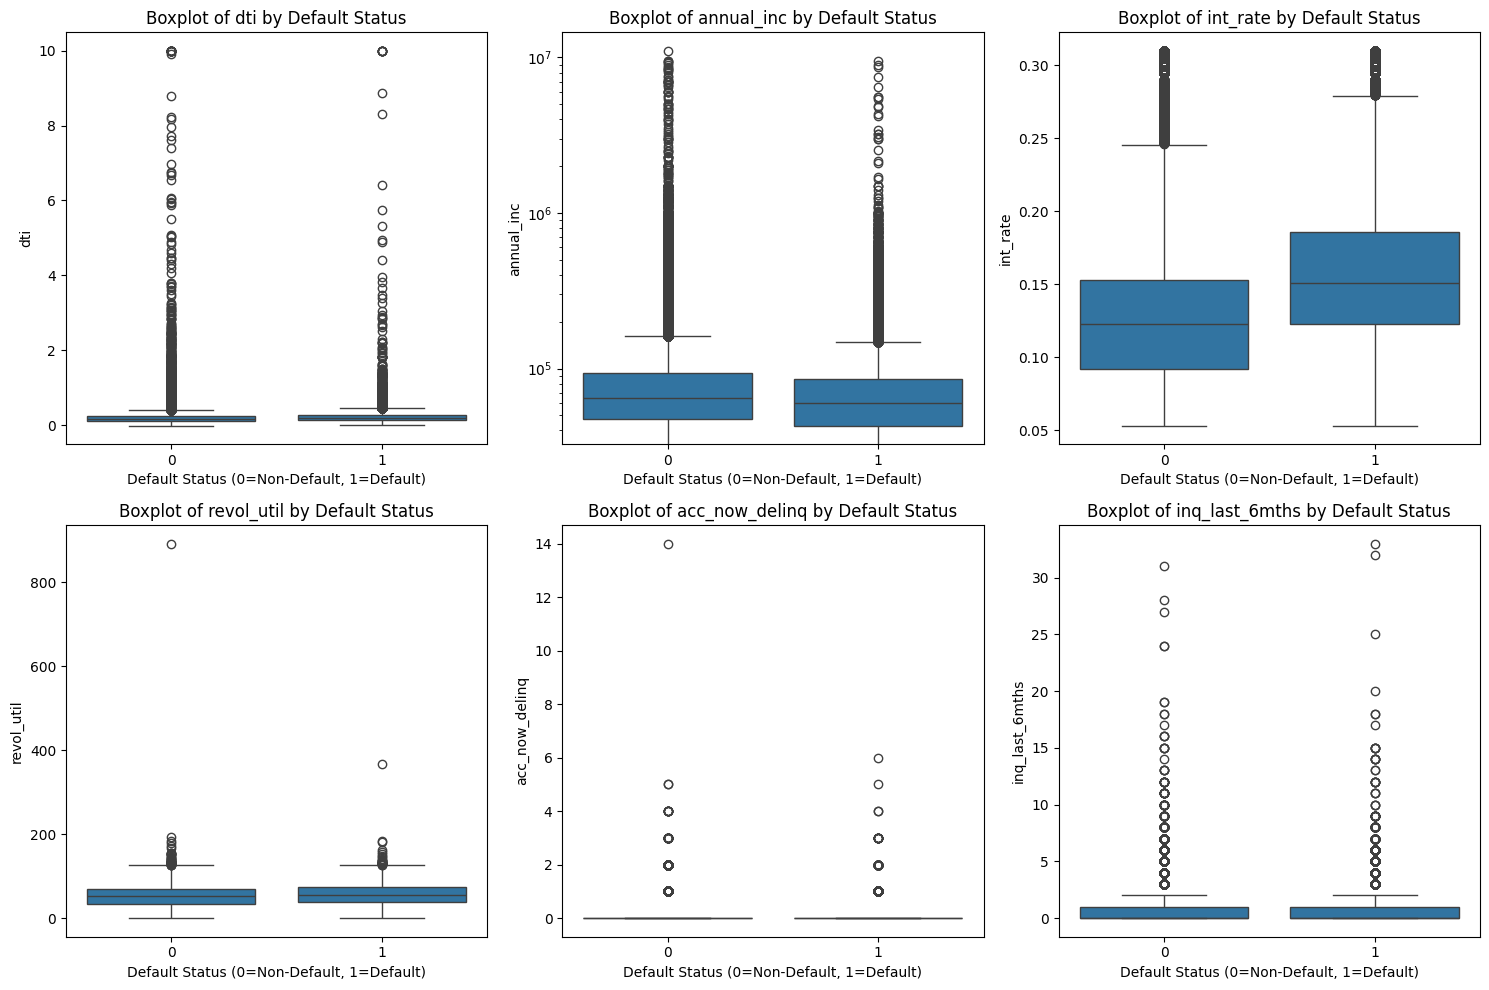

In [15]:
# Create a set for important features for box plots
box_features = ['dti','annual_inc','int_rate','revol_util','acc_now_delinq','inq_last_6mths']

for b in box_features:
    loan_set[b] = pd.to_numeric(loan_set[b], errors='coerce')

loan_set['is_default'] = pd.to_numeric(loan_set['is_default'], errors='coerce')

# Box plots for numerical features by default status
fig,axes = plt.subplots(2,3,figsize=(15,10))
axes = axes.flatten()

for ax,feature in zip(axes, box_features):
    sns.boxplot(x = 'is_default',y=feature,data=loan_set, ax=ax)
    ax.set_title(f'Boxplot of {feature} by Default Status')
    ax.set_xlabel('Default Status (0=Non-Default, 1=Default)')

axes[1].set_yscale('log')
plt.tight_layout()
plt.show()

### **Key inference from the EDA boxplots**
1. Debt-to-Income Ratio (`dti`)
Hihger debt-to-income ratio is strongly associated with default risk

2. Annual Income(`annual_inc`)
Defaulted borrowers tend to have lower median income. Income distributions are highly skewed (long right tail), which is expected in consumer credit data.

3. Interest Rate (`int_rate`)
Interest rates already reflect ex-ante risk assessment by the lender and are strongly correlated with realized default outcomes.

4. Revolving Credit Utilization (`revol_util`)
High revolving credit utilization is a strong indicator of financial strain and default risk.

5. Current Delinquencies (`acc_now_delinq`)
Any current delinquency is a strong red flag despite being infrequent.

6. Recent Credit Inquiries (`inq_last_6mths`)
Increased recent credit-seeking behavior is associated with elevated default risk.

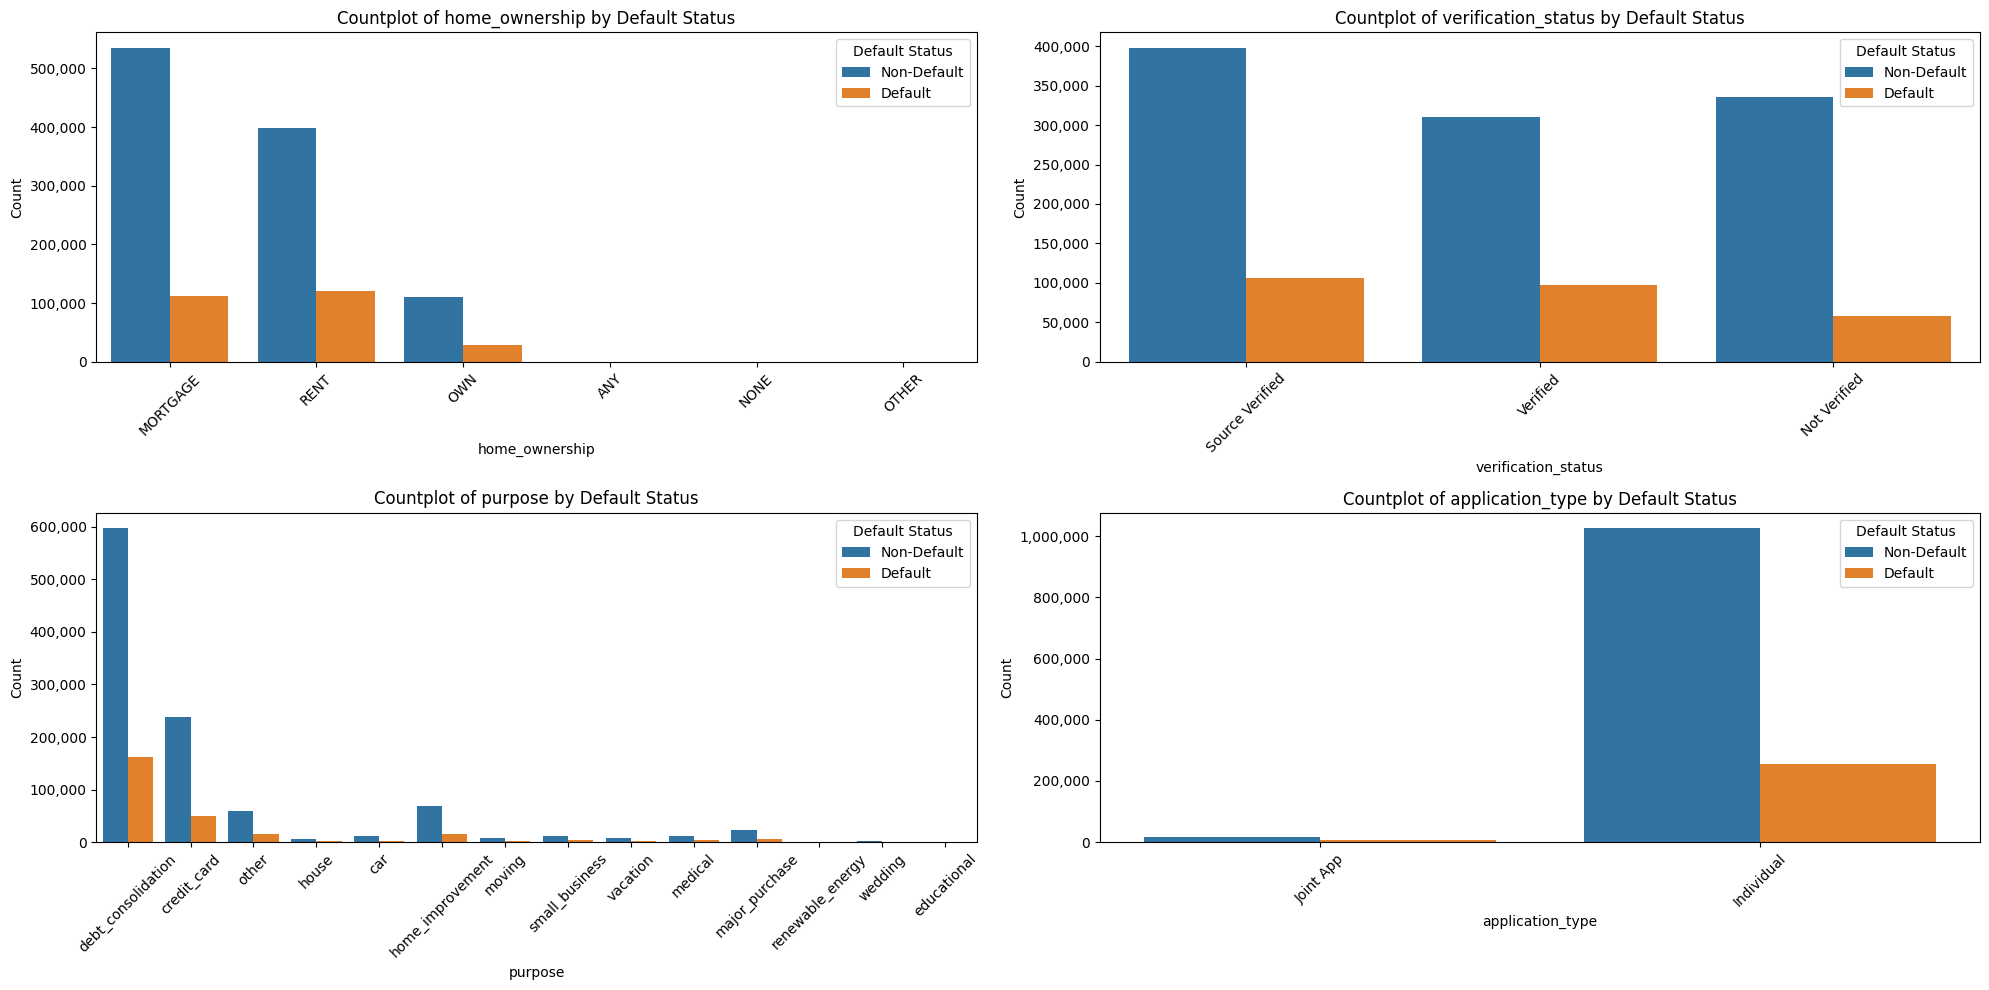

In [16]:
cat_features = loan_set.drop(['earliest_cr_line','loan_status'],axis =1).select_dtypes(include=['object']).columns.tolist()

n = len(cat_features)
cols = 2
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

for ax,feature in zip(axes, cat_features):
    sns.countplot(x=feature, hue='is_default', data=loan_set, ax=ax)
    ax.set_title(f'Countplot of {feature} by Default Status')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.legend(title='Default Status', labels=['Non-Default', 'Default'])
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    for label in ax.get_xticklabels():
        label.set_rotation(45)

for i in range(len(cat_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### **Key Inferences from categorical EDA**

1. Long Term (`term`)
Longer repayment horizons are associated with higher credit risk due to prolonged exposure and greater uncertainty.

2. Employment Length (`emp_length`)
Employment stability is an important indicator of repayment capacity and credit risk.

3. Home Ownership (`home_ownership`)
Home ownership serves as a proxy for financial stability and asset backing.

4. Income Verification Status (`verification_status`)
Income verification improves underwriting quality and reduces default risk.

5. Loan purpose (`sanity check`)
Loan purpose captures behavioral and risk segmentation beyond borrower-level characteristics.

6. Application Type (`application_type`)
The vast majority of loans are individual applications and joint application are rare.

## 6. Modelling

This section develops predictive models to estimate the probability of loan default using the prepared dataset. A logistic regression model is first implemented as a baseline due to its interpretability and widespread use in credit risk modeling. The dataset exhibits moderate class imbalance, with defaulted loans accounting for approximately 20% of observations. This imbalance is addressed using appropriate evaluation metrics and model settings rather than through aggressive resampling. More flexible machine learning models are later introduced for performance comparison.

### **6.1 Logistic Regression( Base model )**
Logistic Regression is a baseline classification model widely used in credit risk modeling because it is interpretable, stable, and regulator-friendly.

It estimates the probability of default (PD) by modeling the log-odds of default as a linear function of borrower and loan characteristics such as income, DTI, interest rate, and loan amount.

In [17]:
# Identify feature set and target variable
loan_set = loan_set.dropna()
x = loan_set.drop(['loan_status','is_default'], axis=1)
y = loan_set['is_default']

# train = 75% , val = 15% , test = 15%
# Create training, validation, and testing sets 
x_train_val, x_test, y_train_val, y_test = train_test_split(
    x, y, test_size=0.15, random_state=42, stratify=y
)
# Create training and testing sets
x_train,x_val,y_train,y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
)  

In [18]:
# Default rate in each dataset
def show_rate(y,name):
    print(f"Default Rate of {name}: {y.mean():.2%}")

show_rate(y_train,'Training Set')
show_rate(y_val,'Validation Set')
show_rate(y_test,'Testing Set')

Default Rate of Training Set: 22.92%
Default Rate of Validation Set: 22.91%
Default Rate of Testing Set: 22.92%


The default rates across train, validation and test are identical. This ensures that moddel is training is not biased toward a particular risk profile and hyperparameter tunning and calibration are statistically valid.

In [19]:
# Create num and cat feature 
num_features = x.select_dtypes(include=['number']).columns
cat_features = x.select_dtypes(include=['object']).columns

# check the total columns
len(num_features) + len(cat_features) == len(x.columns)

True

In [20]:
def evaluate_model_performance(model,x_test,y_test):

    print("Classification Report:")
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"KS Statistic: {ks_2samp(y_proba[y_test == 1], y_proba[y_test == 0]).statistic:.4f}")

This function evaluates a trainded classification using key performance metrics. It computes predcted classes and default probabilities, then reports

- **Classification report** - Precision,recall,F1-score for default vs non-default

- **Confustion Matrix** - Breakdown of correct and incorrect classfications
- **ROC-AUC** - Overall ability of the model to rank risky borrowers above safe one
- **KS Statistic**- Maximum sepration between default and non-default score distribution.

In [21]:
# Create a def to plot all the curve together 

def plot_model_performance(y_test,y_proba,name):

    fig,axes = plt.subplots(2,2,figsize=(16,6))
    axes = axes.flatten()
    # AUC ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    axes[0].plot(fpr,tpr,label=f'AUC = {auc:.4f}')
    axes[0].plot([0,1],[0,1],linestyle='--',label='Random Classifier')
    axes[0].set_title('ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_title(f'ROC Curve - {name}')

    # KS Curve
    df = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})
    df = df.sort_values(by='y_proba', ascending=False)

    df['cum_bad'] = (df['y_test'] == 1).cumsum() / (df['y_test'] == 1).sum()
    df['cum_good'] = (df['y_test'] == 0).cumsum() / (df['y_test'] == 0).sum()
    df['ks'] = abs(df['cum_bad'] - df['cum_good'])

    ks_value = df['ks'].max()
    df['population'] = np.arange(1,len(df)+1)/len(df)
    axes[1].plot(df['population'],df['cum_bad'], label='Cumulative Bad')
    axes[1].plot(df['population'],df['cum_good'], label='Cumulative Good')
    axes[1].plot(df['population'],df['ks'], '--', label=f'KS = {ks_value:.4f}')
    axes[1].set_title('KS Curve')
    axes[1].set_xlabel('Population Proportion')
    axes[1].set_ylabel('Cumulative Rate')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_title(f'KS Curve - {name}')

    # Lift Cumalative Gain Chart
    df['bin'] = pd.qcut(df['y_proba'], 10, labels=False)
    lift = df.groupby('bin')['y_test'].mean()
    baseline = df['y_test'].mean()

    axes[2].plot(lift.index, lift / baseline, marker='o', label='Lift')
    axes[2].set_title('Lift Chart')
    axes[2].set_xlabel('Decile')
    axes[2].set_ylabel('Lift')  
    axes[2].legend()
    axes[2].grid(True)
    axes[2].set_title(f'Lift Chart - {name}')

    # Thershold sensitivity plot
    thresholds = np.arange(0.05,0.95,0.05)

    precision,recall,approval = [],[],[]
    for t in thresholds:
        y_pred_threshold = (y_proba >= t).astype(int)
        precision.append(precision_score(y_test, y_pred_threshold))
        recall.append(recall_score(y_test, y_pred_threshold))
        approval.append((y_pred_threshold == 0).mean())
    
    axes[3].plot(thresholds, precision, label='Precision')
    axes[3].plot(thresholds, recall, label='Recall')
    axes[3].plot(thresholds, approval, label='Approval Rate')
    axes[3].set_title('Threshold Sensitivity')  
    axes[3].set_xlabel('Threshold')
    axes[3].set_ylabel('Rate')
    axes[3].legend()
    axes[3].grid(True)
    axes[3].set_title(f'Threshold Sensitivity - {name}')
    plt.tight_layout()
    plt.show()

This function visualizes multiple credit-risk evaluation metrics in a single view.
It is designed to assess both statistical performance and business usability of a probability-of-default (PD) model.

**1. ROC Curve**\
The ROC curve illustrates the model’s ability to distinguish default from non-default customers across all probability thresholds.

- The diagonal line represents a random classifier (AUC = 0.5).
- The area under the curve (AUC) summarizes overall ranking performance.

**2. KS Curve**\
The KS curve plots the cumulative distribution of defaults and non-defaults after sorting observations by predicted PD.

- The KS statistic is the maximum vertical distance between these two curves.

- It measures how well the model separates risky from safe customers.

**3. Lift Chart — Business Efficiency**\
The lift chart evaluates how much better the model performs compared to random selection by dividing customers into risk deciles.

- Lift > 1 indicates improved default capture over random.
- Higher lift in top deciles means better prioritization of high-risk cases.

**4.Threshold Sensitivity — Policy Trade-offs**\
This plot examines how model decisions change when different PD thresholds are applied.

Metrics shown:

- Recall — proportion of defaults correctly identified.
- Precision — accuracy of default predictions.
- Approval rate — proportion of customers classified as non-default.

In [22]:
# Create preprocessing and modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ]
)

logit_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42,max_iter=1000,solver= 'lbfgs'))
])

In [23]:
# fit the model
logit_pipeline.fit(x_train,y_train)

# Make the predictions
y_val_pred_logit = logit_pipeline.predict(x_val)
y_val_proba_logit = logit_pipeline.predict_proba(x_val)[:, 1]
#Evaluate model performance on validation set
print("Validation Set Performance:")
evaluate_model_performance(logit_pipeline,x_val,y_val)
print("\n")

y_test_pred_logit = logit_pipeline.predict(x_test)
y_test_proba_logit = logit_pipeline.predict_proba(x_test)[:, 1]
# Evaluate model performance
print("Testing Set Performance:")
evaluate_model_performance(logit_pipeline,x_test,y_test)


Validation Set Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.66      0.74     27259
           1       0.35      0.62      0.45      8103

    accuracy                           0.65     35362
   macro avg       0.60      0.64      0.60     35362
weighted avg       0.74      0.65      0.68     35362

Confusion Matrix:
[[17949  9310]
 [ 3042  5061]]
ROC AUC Score: 0.6975
KS Statistic: 0.2887


Testing Set Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.66      0.74     27254
           1       0.35      0.63      0.45      8102

    accuracy                           0.65     35356
   macro avg       0.60      0.64      0.60     35356
weighted avg       0.74      0.65      0.68     35356

Confusion Matrix:
[[17884  9370]
 [ 2994  5108]]
ROC AUC Score: 0.6952
KS Statistic: 0.2891


### **Logistic Regression– Validation & Test Performance Summary**
- The model shows **reasonable discriminatory power** for predicting risk default.

- The KS statistic close to 0.30 for both test validation and test set, indicating that the **model effectively separate high-risk and low-risk borrowers**.

- Performance consistency between validation and test sets suggests that the model can be safely used as a benchmark for comparing more advanced models (e.g., XGBoost, LightGBM).

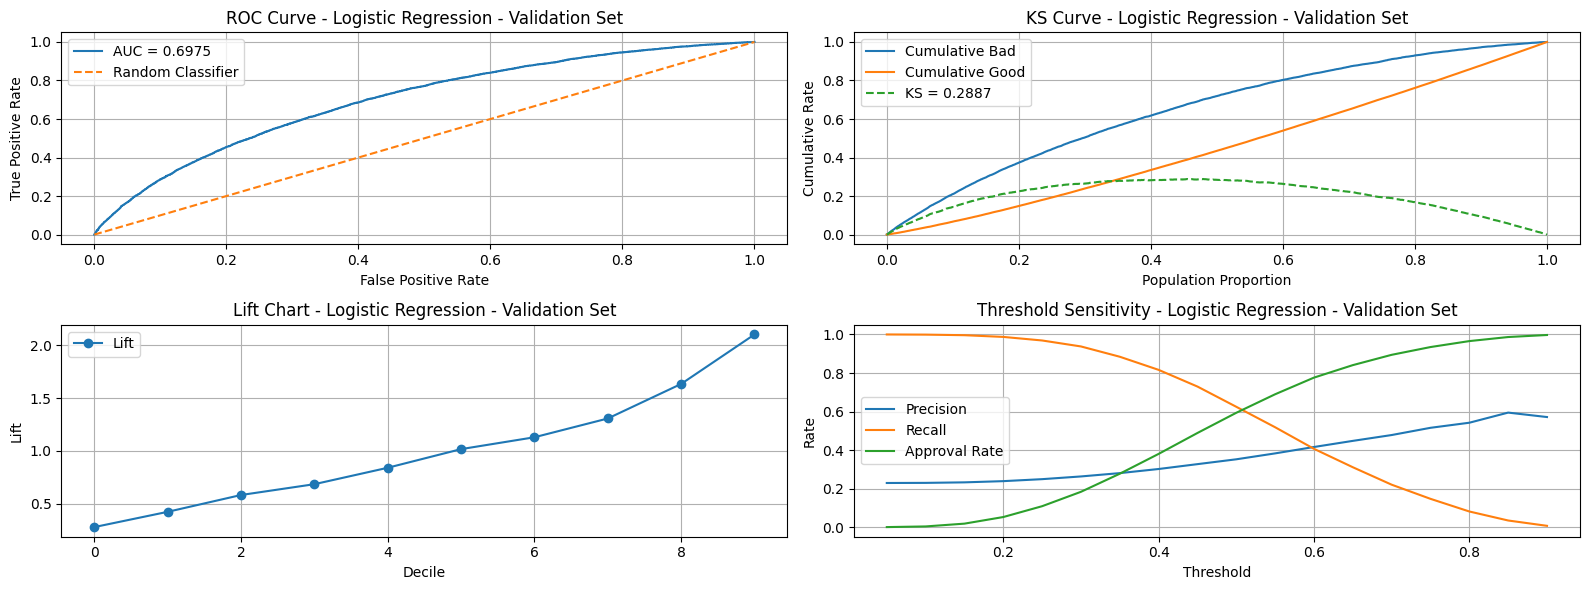

In [24]:
# Plot model performance on validation set
plot_model_performance(y_val,y_val_proba_logit,'Logistic Regression - Validation Set')

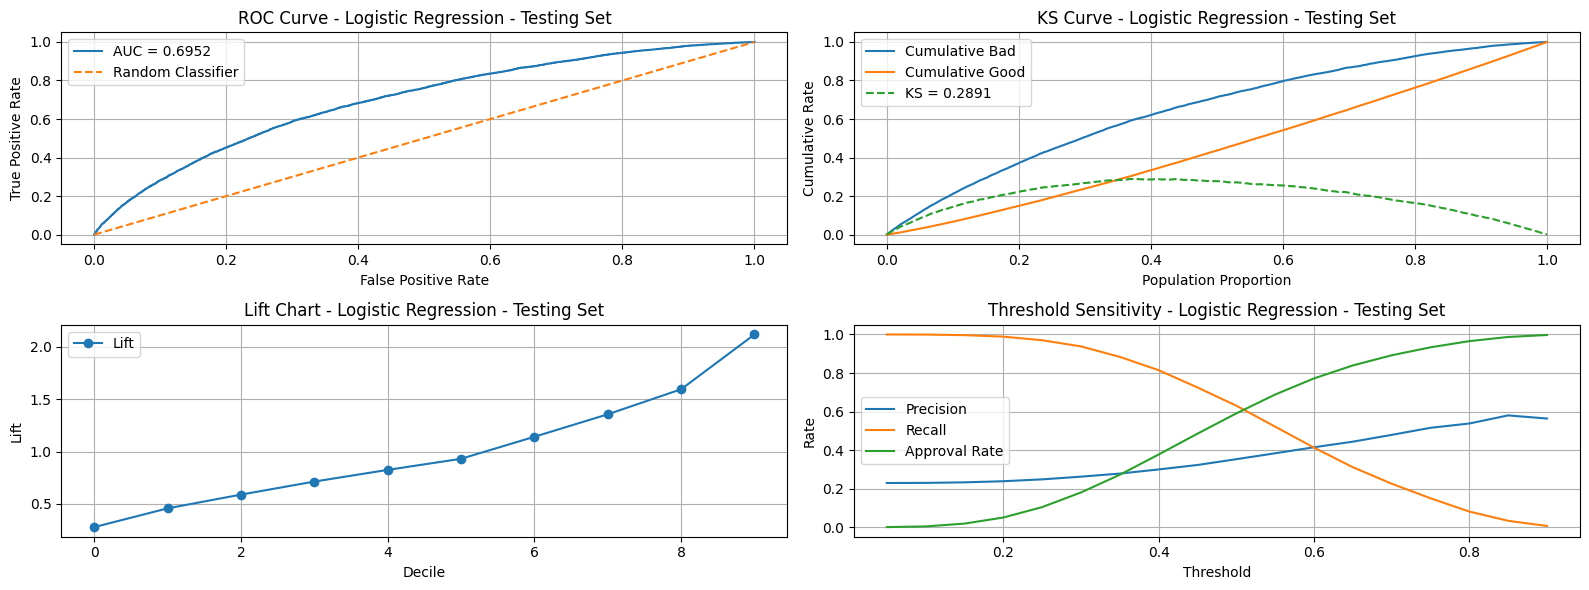

In [25]:
# Plot the model performance on testing set
plot_model_performance(y_test,y_test_proba_logit,'Logistic Regression - Testing Set')  

### **Logistic Regression – Validation & Test plot Summary**

- The ROC curves on both the validation and test sets show a strong separation from random classifier with **AUC $\approx$ 0.7**. This suggests that the mode has meaningful ability to rank higher-risk borrowers before lower risk borrowers

- The KS statistic is close to 0.29 on both samples, which falls in the acceptable to strong range for consumer credit data and confirms that the model provides useful risk discrimination berween defaulters and non-defaulters.

- The close allignment between validation and test AUC and KS illustrates that the model is **stable and not overfitted**, meaning its predictive power generalizes well to unseen borrowers.

- The lift chart show more that 2x lift in the higers risk deciles, confirming that that the **model effectively concentrates defaults in the top-ranked risk segments**.

- The threshold-sensitivity curves illustrate a clear trade-off between recall, precision, and approval rate, showing that business decision thresholds can be flexibly chosen based on risk appetite without destabilizing model behavior.

- The **nearly identical shape of the threshold curves in validation and test** confirms that **decision rules derived from validation will behave similarly in production**, which is essential for operational credit policies.

## 6.2 XG Boost

XGBoost is introduced as a challenger model to capture non-linear relationships and complex feature interactions that may not be adequately modeled by logistic regression.

In [26]:
# Identify XGBoost model with scale_pos_weight
neg = (y_train==0).sum()
pos = (y_train==1).sum()
xg = XGBClassifier(scale_pos_weight= neg/pos, 
                    eval_metric='logloss', 
                    random_state=42)

# Create the 2nd pipeline with XGBoost
XG_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xg)
])

# fit the model
XG_pipeline.fit(x_train,y_train)

# Prediction for validation set
y_val_pred_xg = XG_pipeline.predict(x_val)
y_val_proba_xg = XG_pipeline.predict_proba(x_val)[:, 1]
# Evaluate model performance on validation set
print("XGBoost Validation Set Performance:")
evaluate_model_performance(XG_pipeline,x_val,y_val)
print("\n")

# Prediction for testing set
y_test_pred_xg = XG_pipeline.predict(x_test)
y_test_proba_xg = XG_pipeline.predict_proba(x_test)[:, 1]

# Evaluate model performance
print("XGBoost Testing Set Performance:")
evaluate_model_performance(XG_pipeline,x_test,y_test)

XGBoost Validation Set Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.66      0.75     27259
           1       0.35      0.63      0.45      8103

    accuracy                           0.65     35362
   macro avg       0.61      0.64      0.60     35362
weighted avg       0.74      0.65      0.68     35362

Confusion Matrix:
[[17970  9289]
 [ 2992  5111]]
ROC AUC Score: 0.7031
KS Statistic: 0.2970


XGBoost Testing Set Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.66      0.74     27254
           1       0.35      0.63      0.45      8102

    accuracy                           0.65     35356
   macro avg       0.61      0.64      0.60     35356
weighted avg       0.74      0.65      0.68     35356

Confusion Matrix:
[[17913  9341]
 [ 2977  5125]]
ROC AUC Score: 0.6992
KS Statistic: 0.2912


### **XGBoost – Validation & Test Performance Summary**

- The XGBoost model achieved a **ROC-AUC of approximately 0.70 on both validation and test sets**, indicating **strong and consistent ranking ability** in distinguishing high-risk from low-risk borrowers.

- The **KS statistic is around 0.3 across both samples**, placing the model in the upper-acceptable to strong discrimination range for consumer credit risk.

- The **near-identical AUC and KS values between validation and test** demonstrate that the **model generalizes well and does not exhibit material overfitting**, confirming stability across unseen data.

- Compared with logistic regression, **XGBoost delivers a slightly higher AUC and KS**, suggesting that the model captures non-linear risk patterns and feature interactions that improve default-risk separation.


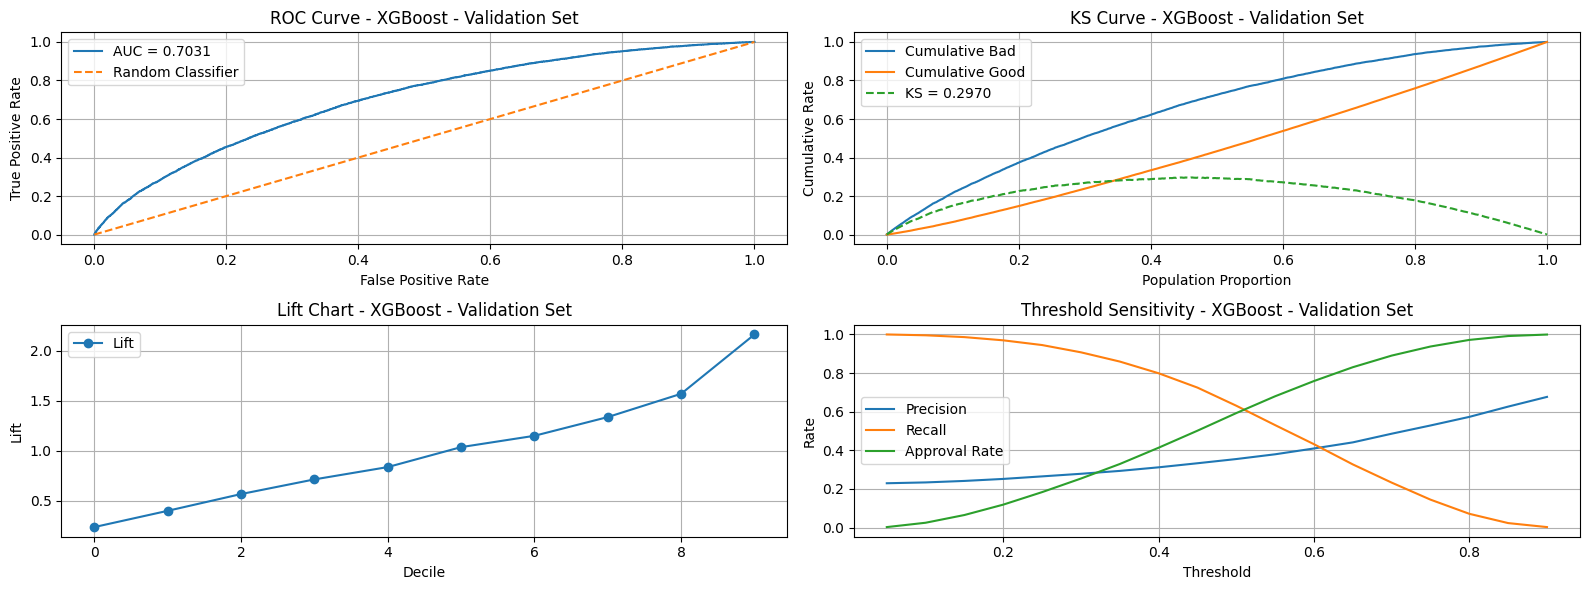

In [27]:
# Plot model performance on validation set
plot_model_performance(y_val,y_val_proba_xg,'XGBoost - Validation Set')

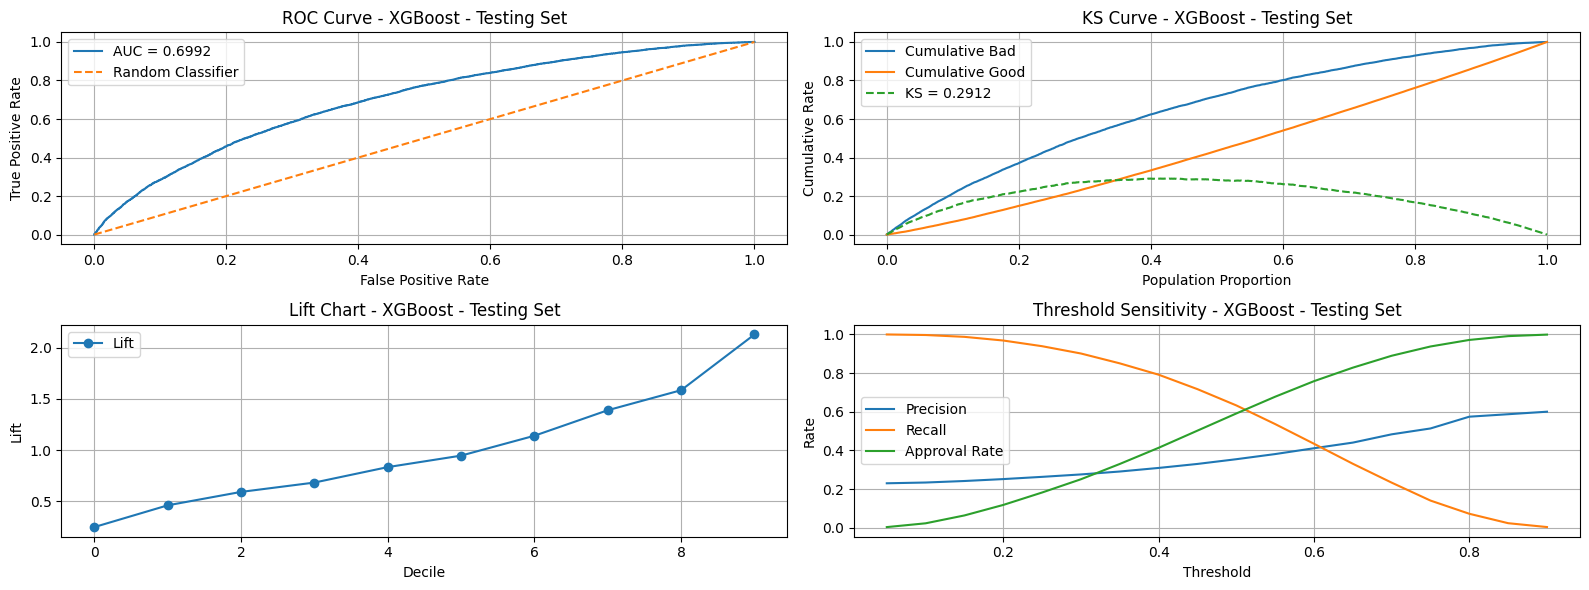

In [28]:
# Plot the model performance on testing set
plot_model_performance(y_test,y_test_proba_xg,'XGBoost - Testing Set')

### **XGBoost – Validation & Test plot Summary**

- The ROC curves for both the validation and test sets **show strong and consistent separation from the random classifier, with AUC ≈ 0.70**, confirming that XGBoost provides robust ranking power for distinguishing high-risk from low-risk borrowers.

- **The KS statistics (≈ 0.30 on both set) indicate strong risk separation**, and are slightly higher than those of logistic regression, reflecting XGBoost’s ability to capture non-linear relationships and feature interactions in credit-risk data.

- The **close alignment of ROC and KS curves between validation and test** demonstrates that the **model generalizes well and is not overfitted**.

- The lift charts show more than 2× lift in the highest-risk deciles, confirming that **XGBoost effectively concentrates defaults in the top-ranked segments**.

- The **similar lift patterns across validation and test** indicate that the **model’s risk ordering is stable**, meaning that the highest-risk borrowers remain consistently identified in unseen data

- The **near-identical threshold curves in validation and test**urther confirm that **decision rules derived from validation will behave consistently in production**.

## Hyperparameter Tunning For XGBoost.

In [29]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    "classifier__max_depth": [3, 5],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__n_estimators": [200, 400],
    "classifier__subsample": [0.8, 1.0],
    "classifier__colsample_bytree": [0.8, 1.0]
}

# Perform grid search
grid = GridSearchCV(estimator=XG_pipeline,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    cv=3,
                    n_jobs=-1,
                    verbose=1)

# fit the model
grid.fit(x_train, y_train)

# Best parameters from grid search
print("Best parameters found: ", grid.best_params_)
print(f"Best ROC AUC Score from Grid Search: {grid.best_score_:.4f}")
print("\n")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters found:  {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best ROC AUC Score from Grid Search: nan




In [30]:
# Get the best model from grid search
xgb_best_model = grid.best_estimator_

# Prediction for validation set with the best model
y_val_pred_grid_xgb = xgb_best_model.predict(x_val)
y_val_proba_grid_xgb = xgb_best_model.predict_proba(x_val)[:, 1]
# Evaluate model performance on validation set
print("XGBoost (Grid Search) Best Model Validation Set Performance:")
evaluate_model_performance(xgb_best_model,x_val,y_val)
print("\n")

# Make predictions with the best model
y_test_pred_grid_xgb = xgb_best_model.predict(x_test)
y_test_proba_grid_xgb = xgb_best_model.predict_proba(x_test)[:, 1]
# Evaluate model performance
print("XGBoost (Grid Search) Best Model Testing Set Performance:")
evaluate_model_performance(xgb_best_model,x_test,y_test)

XGBoost (Grid Search) Best Model Validation Set Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73     27259
           1       0.35      0.67      0.46      8103

    accuracy                           0.64     35362
   macro avg       0.61      0.65      0.60     35362
weighted avg       0.75      0.64      0.67     35362

Confusion Matrix:
[[17266  9993]
 [ 2699  5404]]
ROC AUC Score: 0.7076
KS Statistic: 0.3017


XGBoost (Grid Search) Best Model Testing Set Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73     27254
           1       0.35      0.67      0.46      8102

    accuracy                           0.64     35356
   macro avg       0.61      0.65      0.60     35356
weighted avg       0.75      0.64      0.67     35356

Confusion Matrix:
[[17269  9985]
 [ 2697  5405]]
ROC AUC Score: 0.7067
KS Statistic: 0.

### **XGBoost (Grid Search) – Validation & Test Performance Summary**

- The tuned XGBoost model achieved a **ROC-AUC of ~0.71** on both validation and test sets, which represents a clear improvement over the untuned XGBoost and logistic regression models, indicating stronger overall risk-ranking ability.

 - The **KS statistic increased to around 0.31 on validation and remained above 0.30** on the test set, placing the model firmly in the strong discrimination range for consumer credit-risk data.

- The **very small difference between validation and test performance** (AUC and KS) confirms that hyperparameter tuning did not introduce overfitting and that the model generalizes well to unseen borrowers.

- Compared with the untuned XGBoost:

    - **AUC improved** from ~0.70 → ~0.71

    - **KS improved* from ~0.29 → ~0.31\
    demonstrating that grid-search optimization successfully enhanced risk separation.

- The **tuned model therefore provides stronger and more reliable PD ranking**, which is particularly important for credit QA, risk-based screening, and portfolio-level loss control.


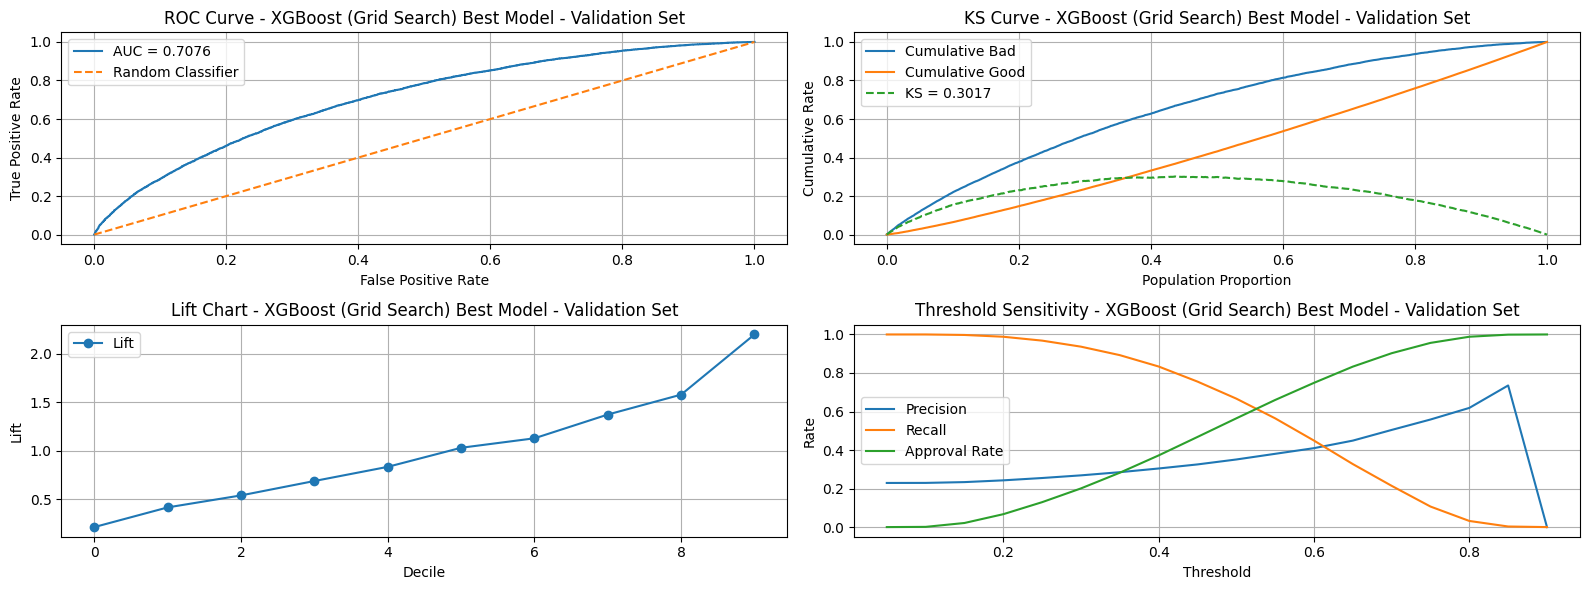

In [31]:
# Plot model performance on validation set
plot_model_performance(y_val,y_val_proba_grid_xgb,'XGBoost (Grid Search) Best Model - Validation Set')

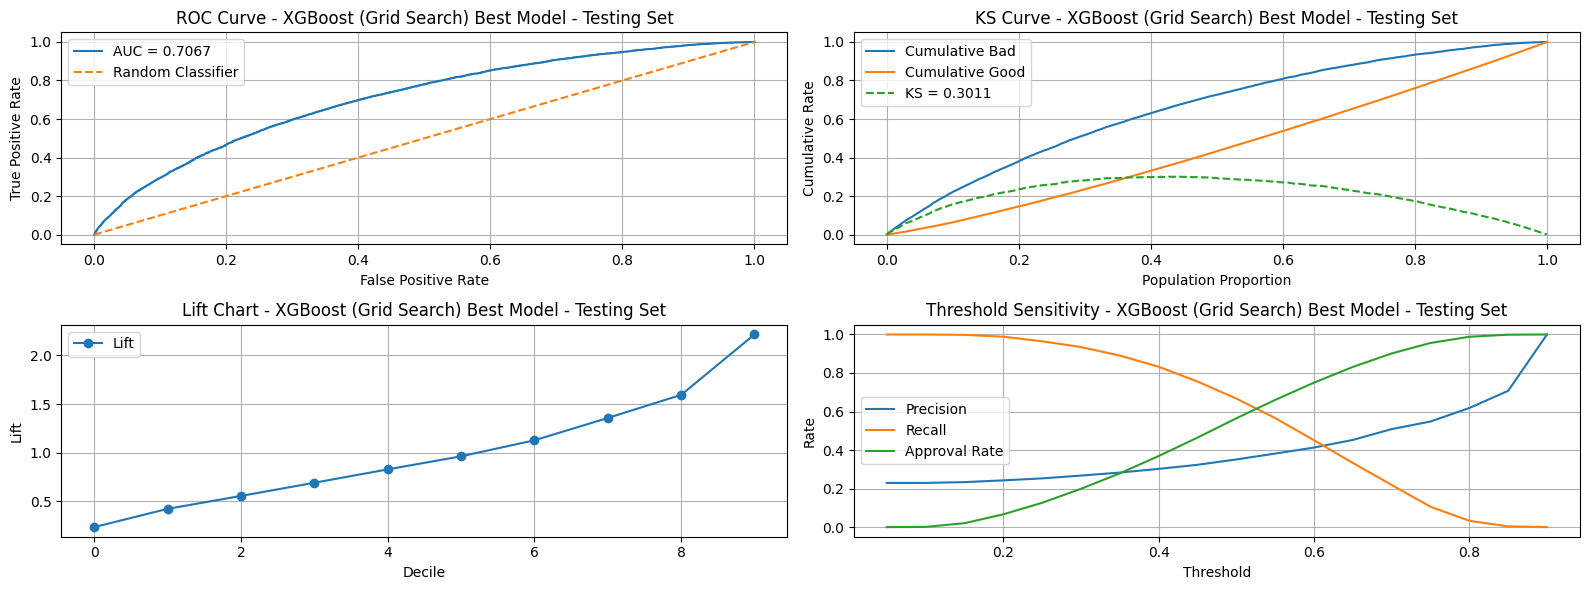

In [32]:
# Plot the model performance on testing set
plot_model_performance(y_test,y_test_proba_grid_xgb,'XGBoost (Grid Search) Best Model - Testing Set')


### **XGBoost (Grid Search) – Validation & Test Performance Summary**

- The ROC curves show clear and consistent separation from the random classifier on both validation and test sets, with **AUC ≈ 0.71**, confirming strong risk-ranking power for distinguishing high-risk from low-risk borrowers.

- The **KS statistics exceed 0.30 on both validation and test**, placing the tuned XGBoost model in the strong discrimination range for consumer credit-risk modeling and outperforming both logistic regression and untuned XGBoost.

- The **very close alignment of ROC and KS between validation and test** demonstrates that **hyperparameter tuning improved performance without introducing overfitting**, indicating that the model generalizes well to unseen borrowers.

- **The lift charts show more than 2× lift in the highest-risk deciles**, confirming that the tuned model effectively concentrates defaults in the top-ranked segments.

- The **consistent lift patterns across validation and test indicate that the risk ordering remains stable**, ensuring that the model’s prioritization of high-risk borrowers is reliable in production.

- The **near-identical threshold behavior in validation and test** further confirms that **decision rules derived from the validation set will behave similarly on new borrowers**.

In [33]:
# Get transformed training and testing data
xgb_x_train_trans = xgb_best_model.named_steps['preprocessor'].transform(x_train)
xgb_x_test_trans = xgb_best_model.named_steps['preprocessor'].transform(x_test)

# Get feature names
feature_names = xgb_best_model.named_steps['preprocessor'].get_feature_names_out()
clean_feature_names = [
    re.sub(r'[\[\]<>]', '_', name)
    for name in feature_names
]
# Convert transformed test data to DataFrame
xgb_x_test_trans_df = pd.DataFrame(xgb_x_test_trans.toarray(),columns=clean_feature_names)
xgb_x_test_trans_df.shape

(35356, 696)

In [34]:
import xgboost
import shap
print(xgboost.__version__)
print(shap.__version__)

1.7.6
0.44.1


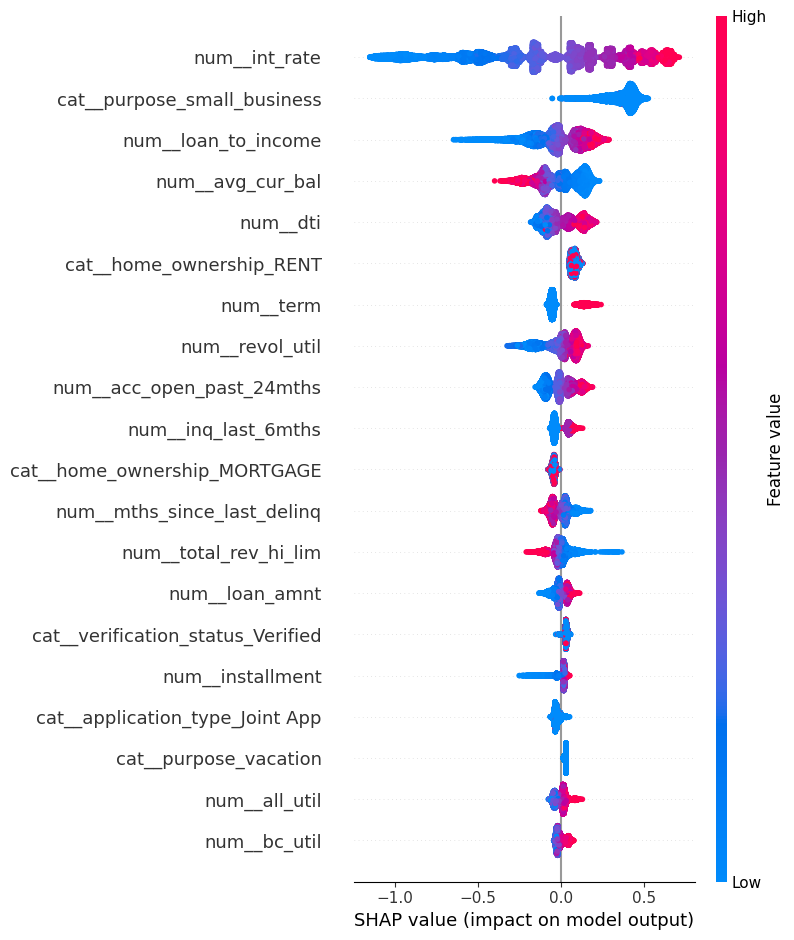

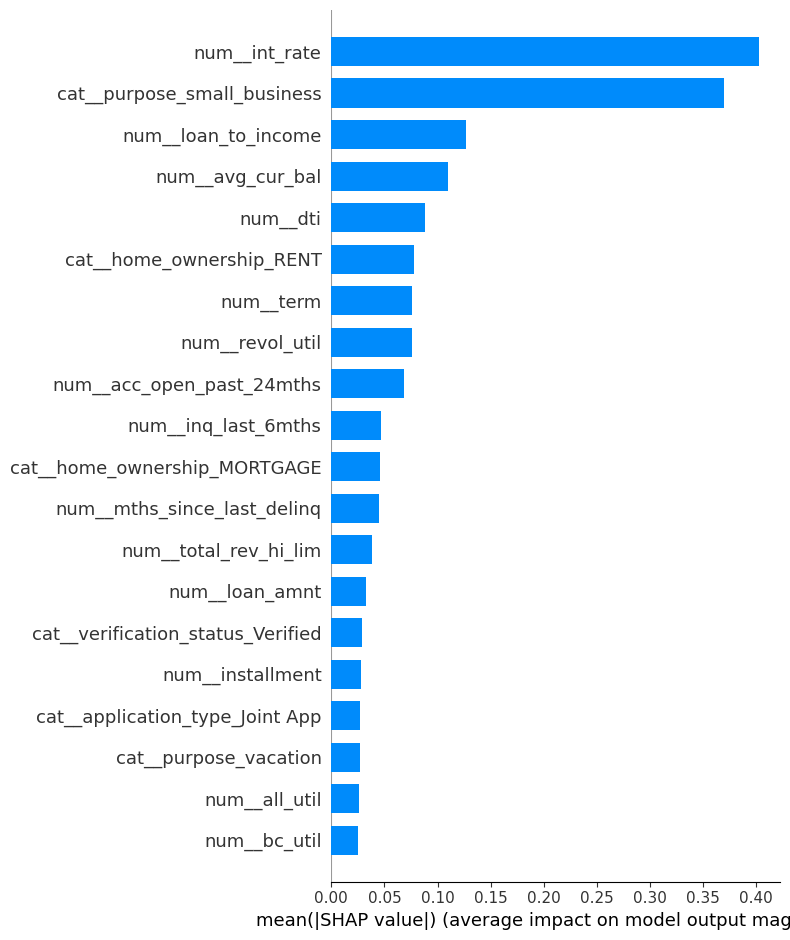

In [35]:
# Global SHAP for XGBoost model
xgb_explainer = shap.TreeExplainer(xgb_best_model.named_steps['classifier'])
xgb_shap_values = xgb_explainer.shap_values(xgb_x_test_trans_df)
shap.summary_plot(xgb_shap_values,xgb_x_test_trans_df)
shap.summary_plot(xgb_shap_values, xgb_x_test_trans_df, plot_type="bar")

### **SHAP Summary Interpretation**

The Shap bar and beeswarm chart shows which variables have the largest average impact on the model's default prediction across borrowers.

The most inflential drivers of default risk are:

- Credit history start date (`earliest_cr_line`)
Different credit group (e.g., 1964, 1971, 1977, 1983) strongly affect predicted risk.
Older and more established credit histories generally indicate **lower default risk**, while newer credit files are associated with **higher uncertainty and risk**.

- Loan purpose - Small business (`cat_purpose_small_business`)
Small-business loans contribute more to default risk than consumer purposes, reflecting **higher volatility and cash-flow uncertainty**.

- Debt-to-Income-ratio (`num_dti`)
DTI is one of the most important continuous risk driver, indicating higher leverage leads to higer default probability.

- Interest rate (`num_int_rate`)
High interest rates are associated with risk borrowers, making a storng risk signal.

- Average current balance (`num_avg_cur_bal`)
Indicates borrower liquidity and financial buffer.

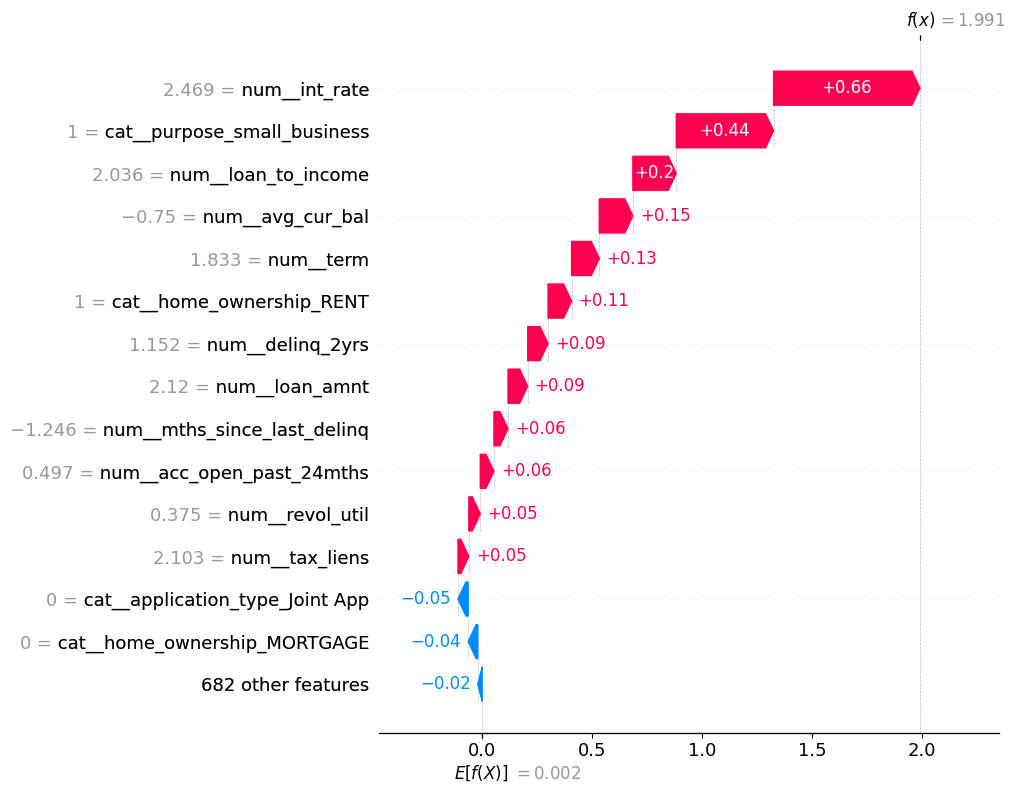

In [36]:
# define the highest risk person 
xg_highest_risk_idx = np.argmax(y_test_proba_grid_xgb)

# Plot the waterfall
xg_explaination = shap.Explanation(
    values=xgb_shap_values[xg_highest_risk_idx],
    base_values=xgb_explainer.expected_value,
    data=xgb_x_test_trans_df.iloc[xg_highest_risk_idx],
    feature_names = clean_feature_names)

shap.waterfall_plot(xg_explaination,max_display=15)

In [37]:
# Probability of Default of the peson in the shap waterfall plot
log_odds1 = xgb_explainer.expected_value # base value
pd1 = 1/(1+np.exp(-log_odds1))

log_odds2 = xgb_explainer.expected_value + xg_explaination.values.sum() # base value + shap values
pd2 = 1/(1+np.exp(-log_odds2))

print(f"Probability of Default of average person in this dataset: {pd1:.4f}")
print(f"Probability of Default of the person in the SHAP waterfall plot: {pd2:.4f}")

Probability of Default of average person in this dataset: 0.5004
Probability of Default of the person in the SHAP waterfall plot: 0.8798


###  **Local SHAP Summmary Interpretation (XGBoost)**

- The baseline model risk for the portfolio is **E[f(X)] ≈ 0.008**, meaning the average borrower has a PD close to 50% before considering any personal information.

- After incorporating this borrower’s characteristics, the model output becomes
**f(x) = −1.606**, which corresponds to a much lower probability of default, indicating that this borrower is significantly safer than the average applicant.

- The largest risk-reducing (protective) factors are:

    - **Long credit history** (multiple early credit line indicators such as 1975–1991)

    - **Long time since last delinquency**

    - **High total credit limits and balances**
    These signals indicate financial maturity and stability, which strongly push the PD downward.

- The main risk-increasing factors for this borrower are:

    - **High interest rate**

    - **Small business loan purpose**

    - **Large loan amount**
    These are typical credit-risk flags that raise PD in consumer lending.

- However, the protective factors dominate the risky ones, which is why the final PD is much lower than the portfolio average.

## 6.3 LightGBM
LightGBM is tested as an efficient gradient boosting challenger to evaluate whether non-linear modeling can deliver performance comparable to XGBoost with improved computational efficiency.

In [38]:
# Create the 3rd pipeline with LightGBM
lightgbm = LGBMClassifier(class_weight='balanced', random_state=42)

pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lightgbm)
])

pipeline_lgbm.fit(x_train,y_train)

# Prediction for validation set
y_val_pred_lgbm = pipeline_lgbm.predict(x_val)
y_val_proba_lgbm = pipeline_lgbm.predict_proba(x_val)[:, 1]
# Evaluate model performance on validation set
print("\n")
print("LightGBM Validation Set Performance:")
evaluate_model_performance(pipeline_lgbm,x_val,y_val)
print("\n")

# prediction for testing set
y_test_pred_lgbm = pipeline_lgbm.predict(x_test)
y_test_proba_lgbm = pipeline_lgbm.predict_proba(x_test)[:, 1]
print("LightGBM Testing Set Performance:")
evaluate_model_performance(pipeline_lgbm,x_test,y_test)

[LightGBM] [Info] Number of positive: 37807, number of negative: 127180
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 164987, number of used features: 497
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LightGBM Validation Set Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.64      0.74     27259
           1       0.35      0.66      0.46      8103

    accuracy                           0.65     35362
   macro avg       0.61      0.65      0.60     35362
weighted avg       0.75      0.65      0.67     35362

Confusion Matrix:
[[17484  9775]
 [ 2745  5358]]
R

### **LightGBM – Validation & Test Performance Summary**

- The LightGBM model achieved a **ROC-AUC of approximately 0.71** on both validation and test sets, indicating strong ability to rank borrowers by default risk and performance comparable to the tuned XGBoost model.

- The **KS statistic is slightly above 0.30** on both validation and test, placing the model in the strong discrimination range for consumer credit-risk data and confirming effective separation between defaulters and non-defaulters.

- The **very small difference between validation and test AUC and KS** shows that the **model is stable and not overfitted**, meaning it generalizes well to unseen borrowers.

- Compared with untuned models, **LightGBM delivers meaningfully stronger KS and slightly higher AUC**, demonstrating its ability to capture complex non-linear risk patterns in borrower behavior.

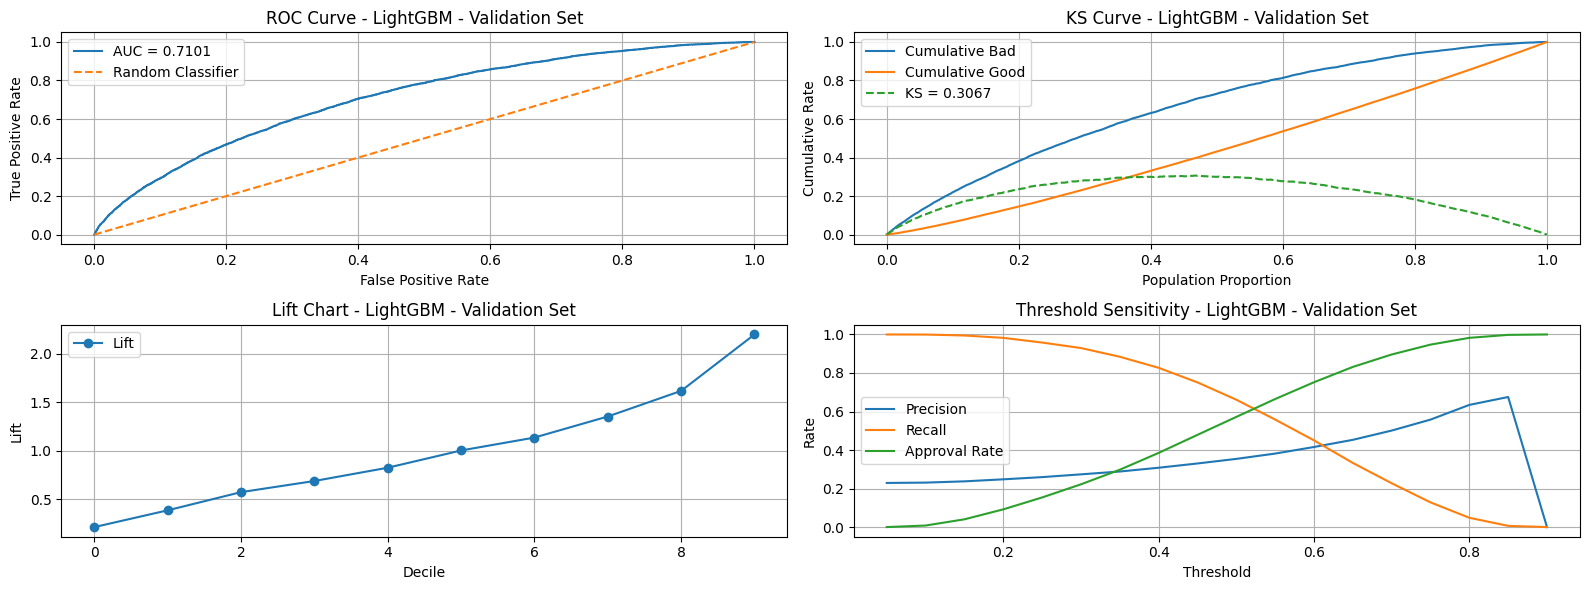

In [39]:
# Plot the model performance on testing set
plot_model_performance(y_val,y_val_proba_lgbm,'LightGBM - Validation Set')

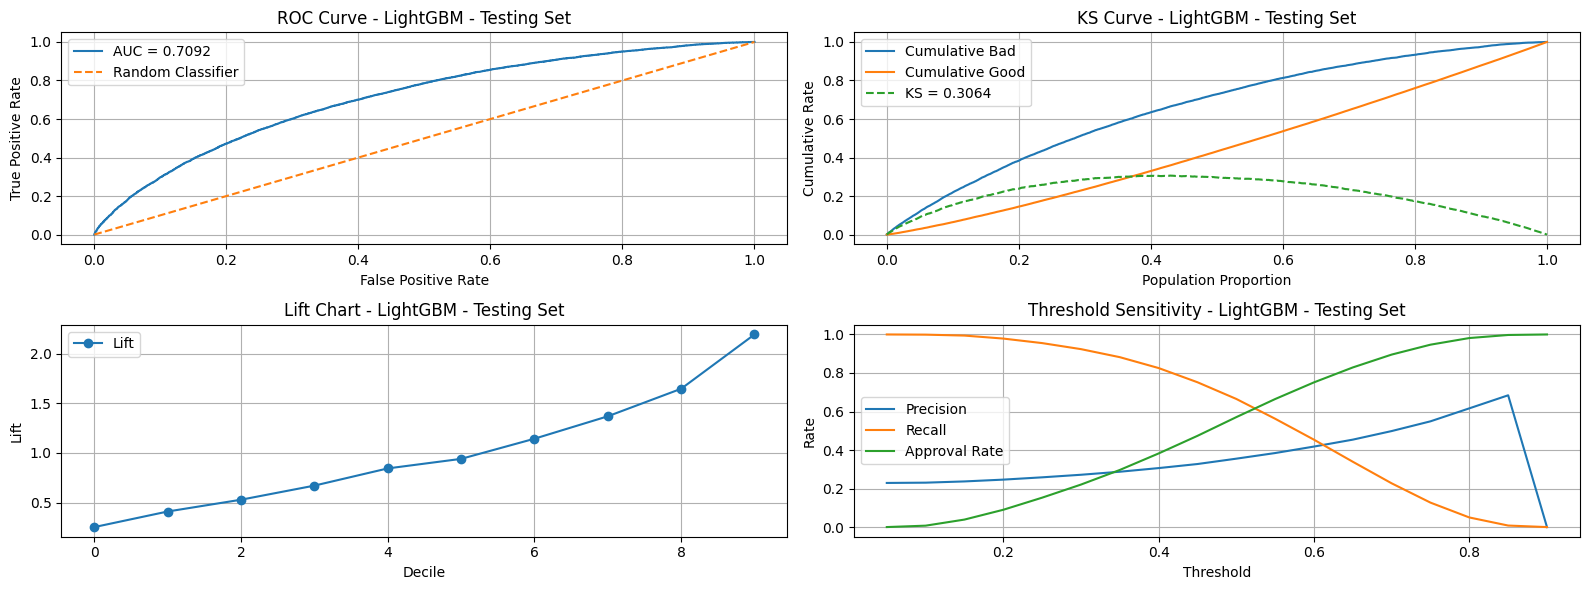

In [40]:
# Plot model performance on test set
plot_model_performance(y_test,y_test_proba_lgbm,'LightGBM - Testing Set')

### **LightGBM – Validation & Test Plot Summary**
- The ROC curves for both validation and test sets show strong and consistent separation from the random classifier, with **AUC ≈ 0.71**, confirming that LightGBM provides robust ranking power for distinguishing high-risk from low-risk borrowers.

- **The KS statistics exceed 0.30 on both validation and test**, indicating strong risk separation and placing LightGBM in the top tier of discriminatory performance among the evaluated models.

- **The very close alignment of ROC and KS curves between validation and test** demonstrates that the **model generalizes well and is not overfitted**.

- **The lift charts show more than 2× lift in the highest-risk deciles**, confirming that LightGBM effectively concentrates defaults in the top-ranked segments, which is critical for credit screening, QA prioritization, and risk-based portfolio management.

- **The similar lift profiles across validation and test** indicate that the **model’s risk ordering is stable**, ensuring that high-risk borrowers remain consistently identified in unseen data.

- **The near-identical threshold behavior in validation and test** confirms that **decision rules derived from validation will behave consistently in production**.

## Hyperparemeter Tunning for LightGBM

In [41]:
param_grid_lgbm = {
    "classifier__num_leaves": [31, 63],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__n_estimators": [300, 500],
    "classifier__min_child_samples": [20, 50],
    "classifier__subsample": [0.8, 1.0]
}

grid_lgbm = GridSearchCV(estimator=pipeline_lgbm,
                        param_grid=param_grid_lgbm,
                        scoring='roc_auc',
                        cv=3,
                        n_jobs=-1,
                        verbose=1)

grid_lgbm.fit(x_train, y_train)
print("Best parameters found: ", grid_lgbm.best_params_)
print(f"Best ROC AUC Score from Grid Search: {grid_lgbm.best_score_:.4f}")

# Prediction for validation set with the best model
y_val_pred_grid_lgbm = grid_lgbm.predict(x_val)
y_val_proba_grid_lgbm = grid_lgbm.predict_proba(x_val)[:, 1]
# Evaluate model performance on validation set
print("\n")
print("LightGBM (Grid Search) Best Model Validation Set Performance:")
evaluate_model_performance(grid_lgbm,x_val,y_val)
print("\n")
# prediction for testing set
print("LightGBM (Grid Search) Best Model Testing Set Performance:")
y_test_pred_grid_lgbm = grid_lgbm.predict(x_test)
y_test_proba_grid_lgbm = grid_lgbm.predict_proba(x_test)[:, 1]
evaluate_model_performance(grid_lgbm,x_test,y_test)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Info] Number of positive: 37807, number of negative: 127180
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4613
[LightGBM] [Info] Number of data points in the train set: 164987, number of used features: 425
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best parameters found:  {'classifier__learning_rate': 0.05, 'classifier__min_child_samples': 50, 'classifier__n_estimators': 300, 'classifier__num_leaves': 31, 'classifier__subsample': 0.8}
Best ROC AUC Score from Grid Search: 0.7064


LightGBM (Grid Search) Best Model Validation Set Performance:
Classification Report:
              precision    recall  f1-score   support

  

### **LightGBM (Grid-Search) – Validation & Test Performance Summary**
- The tuned LightGBM model **achieves a ROC-AUC of approximately 0.71 on both validation and test sets**, confirming strong risk-ranking power that is comparable to the tuned XGBoost model.

- The **KS statistic remains above 0.31 on the test set**, placing the model firmly in the strong discrimination range, meaning it effectively separates high-risk and low-risk borrowers.

- The **very small difference between validation and test AUC and KS** indicates that **hyperparameter tuning did not introduce overfitting**, and the model generalizes well to unseen data.

- Compared with the untuned LightGBM:

    - **KS improved (≈ 0.305 → ≈ 0.312)**

    - **AUC remained stable**,
    showing that grid search improved risk separation without sacrificing stability.

- **The recall for defaulters (~66%) is stable across both samples**, meaning the tuned model consistently captures a large proportion of risky loans, which is essential for credit-quality assurance and loss prevention.


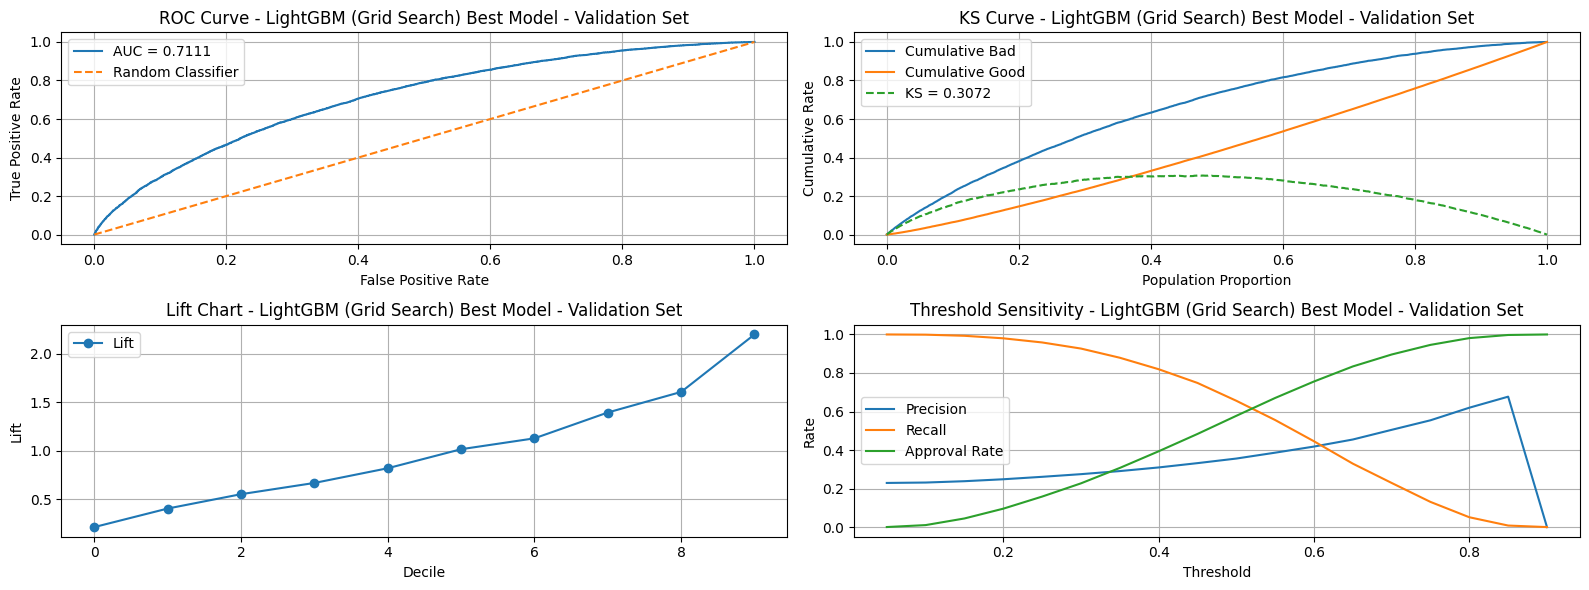

In [42]:
# Plot the model performance on validation set
plot_model_performance(y_val,y_val_proba_grid_lgbm,'LightGBM (Grid Search) Best Model - Validation Set')

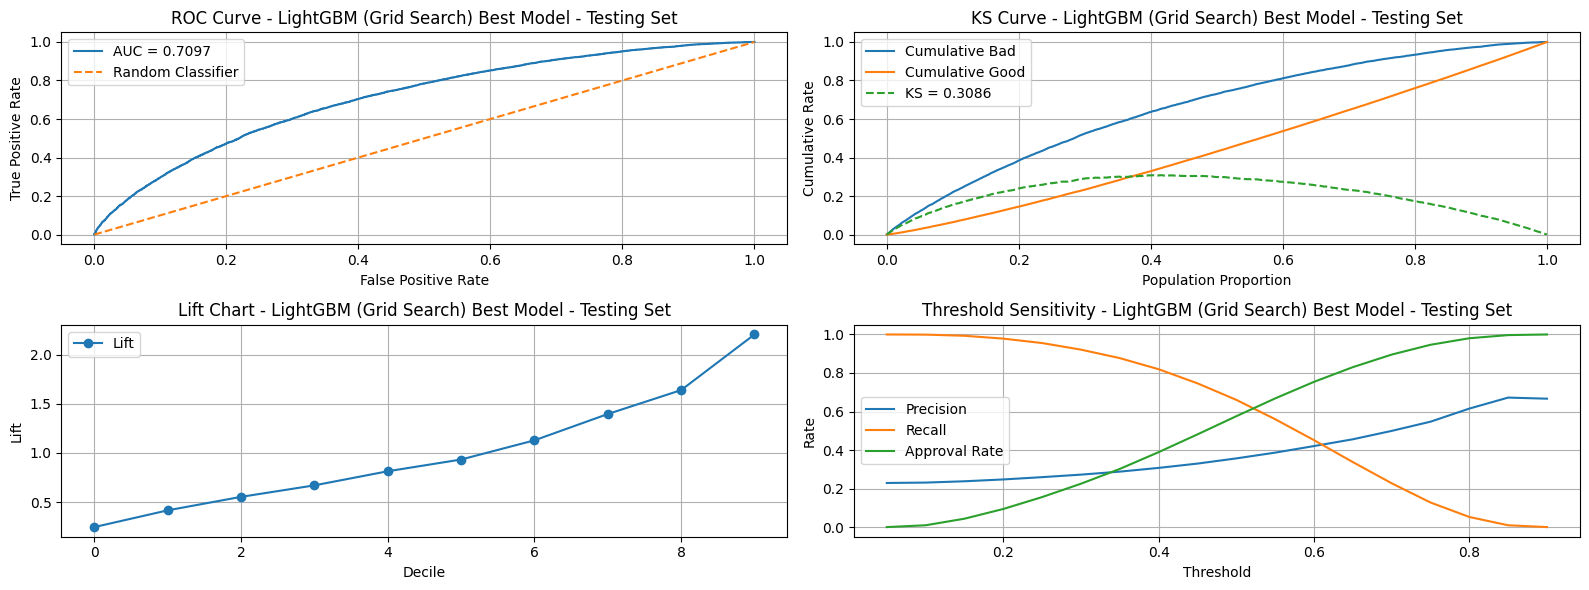

In [43]:
# Plot the model performance on testing set
plot_model_performance(y_test,y_test_proba_grid_lgbm,'LightGBM (Grid Search) Best Model - Testing Set')

### **LightGBM (Grid-Search) – Validation & Test Plot Summary**

In [53]:
# shap for lightgbm model
# Get transformed training and testing data
lightgbm_best_model = grid_lgbm.best_estimator_
lightgbm_x_train_trans = lightgbm_best_model.named_steps['preprocessor'].transform(x_train)
lightgbm_x_test_trans = lightgbm_best_model.named_steps['preprocessor'].transform(x_test)

# Get feature names
feature_names = lightgbm_best_model.named_steps['preprocessor'].get_feature_names_out()
clean_feature_names = [
    re.sub(r'[\[\]<>]', '_', name)
    for name in feature_names
]
# Convert transformed test data to DataFrame
lightgbm_x_test_trans_df = pd.DataFrame(lightgbm_x_test_trans.toarray(),columns=clean_feature_names)
lightgbm_x_test_trans_df.shape

(35356, 696)

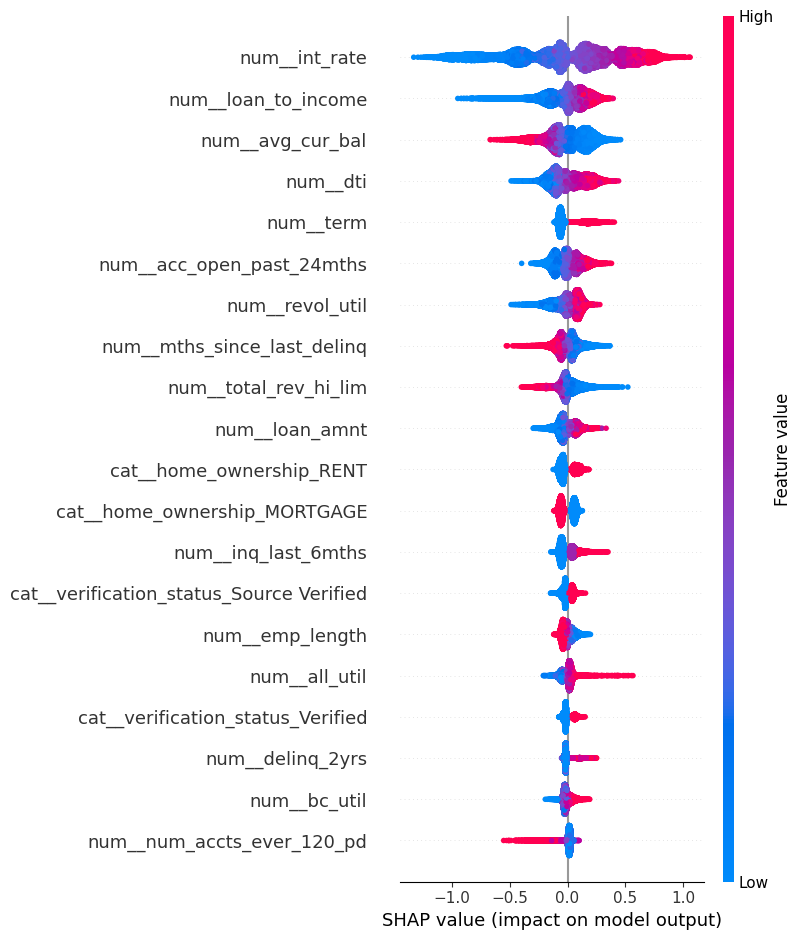

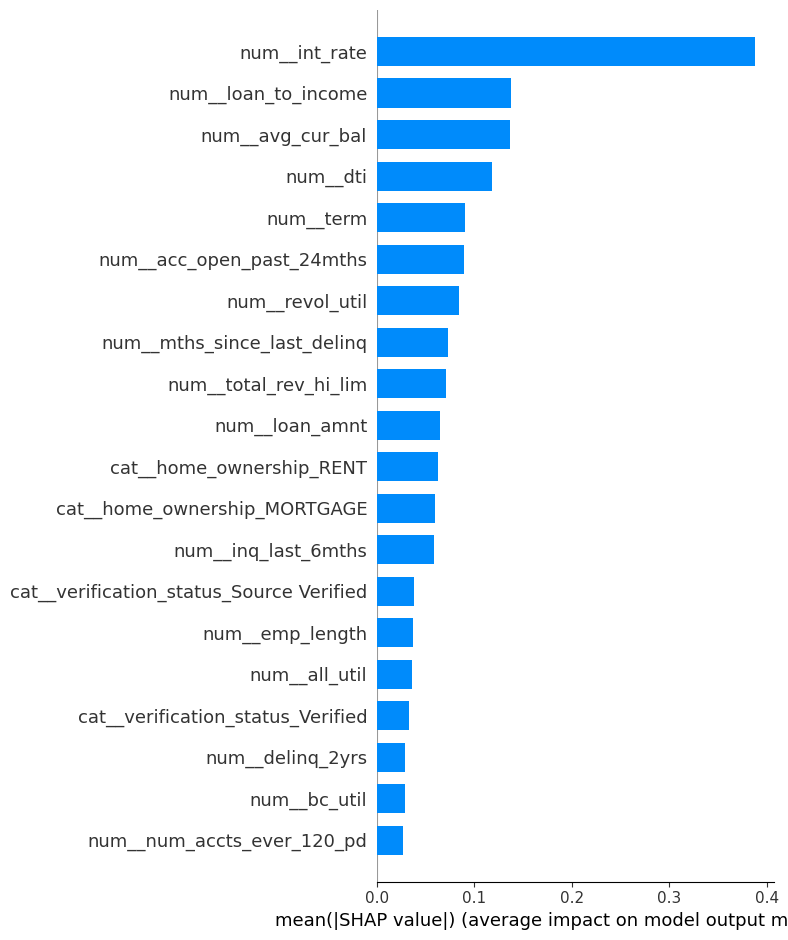

In [55]:
lightgbm_explainer = shap.TreeExplainer(lightgbm_best_model.named_steps['classifier'])
lightgbm_shap_values = lightgbm_explainer.shap_values(lightgbm_x_test_trans_df)

shap_value_default = lightgbm_shap_values[1]  # for the positive class
expected_default = lightgbm_explainer.expected_value[1]  # for the positive class

shap.summary_plot(shap_value_default,lightgbm_x_test_trans_df)
shap.summary_plot(shap_value_default, lightgbm_x_test_trans_df, plot_type="bar")

### **Global SHAP Summary Interpretation**
- Interest rate (`num_int_rate`) is the main driver:\
higer interest rates increase default risk, while lower interest rates reduce it.

- Loan Amount (`num_loan_amnt`):\
larger loand are associated with higer default risk

- Average Current Balance ( `num_avg_cal_bal`):\
Higer current balance can reduct the risk of default.

- Debt-to-income-ration (`num_dti`):\
Higer DTI leads to higer predicted default risk

- Credit utilization (`num__revol_util`, `num__all_util`):
higher utilization increases risk, indicating financial stress.

- Annual income and credit limits:\
higher income and larger credit limits lower default risk.

- Loan structure (e.g., 60-month term, higher installment):\
longer and heavier repayment obligations increase default risk.

- Borrower stability (mortgage ownership, long employment, verified income):\
these features are associated with lower default risk.

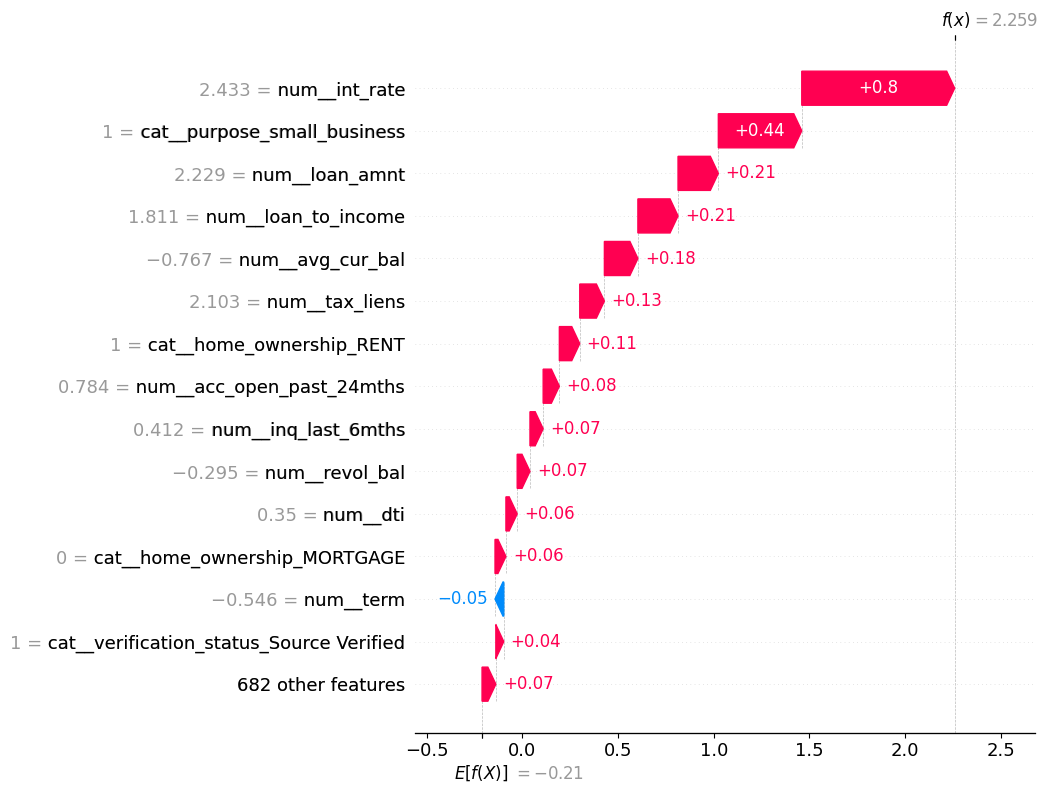

In [56]:
lgbm_highest_risk_idx = np.argmax(y_test_proba_grid_lgbm)

explaination = shap.Explanation(
    values=shap_value_default[lgbm_highest_risk_idx],
    base_values=expected_default,
    data=lightgbm_x_test_trans_df.iloc[lgbm_highest_risk_idx],
    feature_names = clean_feature_names)

shap.waterfall_plot(explaination,max_display=15)

In [ ]:
# Probability of Default of the peson in the shap waterfall plot
log_odds1 = lightgbm_explainer.expected_value # base value
pd1 = 1/(1+np.exp(-log_odds1))

log_odds2 = lightgbm_explainer.expected_value + explaination.values.sum() # base value + shap values
pd2 = 1/(1+np.exp(-log_odds2))

print(f"Probability of Default of average person in this dataset: {pd1:.4f}")
print(f"Probability of Default of the person in the SHAP waterfall plot: {pd2:.4f}")

Probability of Default of average person in this dataset: 0.4476
Probability of Default of the person in the SHAP waterfall plot: 0.9054


### **Local SHAP Interpretation**

- The baseline portfolio risk is **E[f(X)] = −0.21**, corresponding to a Probability of Default (PD) of **~44.8%** for the average borrower.

- This borrower’s model output is **f(x) = 2.259**, which converts to a PD of **~90.9%**, indicating an extremely high-risk profile.

- The borrower is therefore more than twice as risky as the average applicant, placing them clearly in the **Reject / High-Risk** category.

- The largest risk-increasing drivers are:

    - Very high interest rate

    - Low total revolving credit limit

    - Large loan amount

    - 60-month loan term

    - Renting rather than owning

    - High recent credit inquiries

    - High debt-to-income ratio

    - Recent delinquencies and repayment stress

These risk factors compound rather than offset each other, pushing the borrower’s PD sharply upward from the portfolio baseline.

## 7. Model Performance Comparison

Multiple models were trained and evaulated to identify the best cannidate for credit risk prediction, including Logistic Regression, XGBoost, and LightGBM, also along with the grid search optimized version.

To ensure a fair and compreheansive comparision, both **classification performance** and **ranking power** were assessed

### 7.1 Validation Set

In [57]:
result_val = results = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost','XGBoost (grid)', 'LightGBM','LightGBM (grid)'],
    'Precision':[precision_score(y_val, y_val_pred_logit),
                precision_score(y_val, y_val_pred_xg),
                precision_score(y_val, y_val_pred_grid_xgb),
                precision_score(y_val, y_val_pred_lgbm),
                precision_score(y_val, y_val_pred_grid_lgbm)],
    'Recall':[recall_score(y_val, y_val_pred_logit),
              recall_score(y_val, y_val_pred_xg),
              recall_score(y_val, y_val_pred_grid_xgb),
              recall_score(y_val, y_val_pred_lgbm),
              recall_score(y_val, y_val_pred_grid_lgbm)],
    'F1-Score':[f1_score(y_val, y_val_pred_logit),
                f1_score(y_val, y_val_pred_xg),
                f1_score(y_val, y_val_pred_grid_xgb),
                f1_score(y_val, y_val_pred_lgbm),
                f1_score(y_val, y_val_pred_grid_lgbm)],
    'ROC AUC':[roc_auc_score(y_val, y_val_proba_logit),
               roc_auc_score(y_val, y_val_proba_xg),
               roc_auc_score(y_val, y_val_proba_grid_xgb),
               roc_auc_score(y_val, y_val_proba_lgbm),
               roc_auc_score(y_val, y_val_proba_grid_lgbm)],
    'KS Statistic':[ks_2samp(y_val_proba_logit[y_val == 0], y_val_proba_logit[y_val == 1]).statistic,
                    ks_2samp(y_val_proba_xg[y_val == 0], y_val_proba_xg[y_val == 1]).statistic,
                    ks_2samp(y_val_proba_grid_xgb[y_val == 0], y_val_proba_grid_xgb[y_val == 1]).statistic,
                    ks_2samp(y_val_proba_lgbm[y_val == 0], y_val_proba_lgbm[y_val == 1]).statistic,
                    ks_2samp(y_val_proba_grid_lgbm[y_val == 0], y_val_proba_grid_lgbm[y_val == 1]).statistic]
})

results_val = result_val.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
results_val.index = results_val.index + 1
results_val

,Model,Precision,Recall,F1-Score,ROC AUC,KS Statistic
1,LightGBM (grid),0.355809,0.655806,0.461325,0.711133,0.307184
2,LightGBM,0.354061,0.661237,0.461181,0.710114,0.306674
3,XGBoost (grid),0.350977,0.666913,0.459915,0.707581,0.301713
4,XGBoost,0.354931,0.630754,0.454251,0.703093,0.296951
5,Logistic Regression,0.352168,0.624583,0.450387,0.697527,0.288718


### 7.2 Test Set 

In [58]:
results_test = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost','XGBoost (grid)', 'LightGBM','LightGBM (grid)'],
    'Precision':[precision_score(y_test, y_test_pred_logit),
                precision_score(y_test, y_test_pred_xg),
                precision_score(y_test, y_test_pred_grid_xgb),
                precision_score(y_test, y_test_pred_lgbm),
                precision_score(y_test, y_test_pred_grid_lgbm)],
    'Recall':[recall_score(y_test, y_test_pred_logit),
              recall_score(y_test, y_test_pred_xg),
              recall_score(y_test, y_test_pred_grid_xgb),
              recall_score(y_test, y_test_pred_lgbm),
              recall_score(y_test, y_test_pred_grid_lgbm)],
    'F1-Score':[f1_score(y_test, y_test_pred_logit),
                f1_score(y_test, y_test_pred_xg),
                f1_score(y_test, y_test_pred_grid_xgb),
                f1_score(y_test, y_test_pred_lgbm),
                f1_score(y_test, y_test_pred_grid_lgbm)],
    'ROC AUC':[roc_auc_score(y_test, y_test_proba_logit),
               roc_auc_score(y_test, y_test_proba_xg),
               roc_auc_score(y_test, y_test_proba_grid_xgb),
               roc_auc_score(y_test, y_test_proba_lgbm),
               roc_auc_score(y_test, y_test_proba_grid_lgbm)],
    'KS Statistic':[ks_2samp(y_test_proba_logit[y_test == 0], y_test_proba_logit[y_test == 1]).statistic,
                    ks_2samp(y_test_proba_xg[y_test == 0], y_test_proba_xg[y_test == 1]).statistic,
                    ks_2samp(y_test_proba_grid_xgb[y_test == 0], y_test_proba_grid_xgb[y_test == 1]).statistic,
                    ks_2samp(y_test_proba_lgbm[y_test == 0], y_test_proba_lgbm[y_test == 1]).statistic,
                    ks_2samp(y_test_proba_grid_lgbm[y_test == 0], y_test_proba_grid_lgbm[y_test == 1]).statistic]
})

results_test = results_test.sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
results_test.index = results_test.index + 1
results_test

,Model,Precision,Recall,F1-Score,ROC AUC,KS Statistic
1,LightGBM (grid),0.356800,0.660578,0.463337,0.709683,0.308572
2,LightGBM,0.355213,0.665268,0.463138,0.709211,0.306385
3,XGBoost (grid),0.351202,0.667119,0.460157,0.706685,0.301061
4,XGBoost,0.354279,0.632560,0.454183,0.699212,0.291159
5,Logistic Regression,0.352811,0.630462,0.452436,0.695203,0.289072


### **Model Comparison – Validation & Test Summary**
- Tunned XGBoost and Tunned LightGBM clearly outperform Logsitic Regression. This confirms that non-linear models provide superior risk discrimination for the credit-risk data set.

- On the validation set:
    - **XGBoost (grid)** achieves the **highest ROC-AUC (~ 0.71)** and **higherst KS(~0.31)**, making it **statistical winner for model selection**.
    - **LightGBM (grid)** and **LightGBM (base)** deliver **nearly identical AUC and KS**, indicating very similar ranking power to XGBoost.
- On the test set
    - **LightGBM (grid) achieves the highest KS (0.3120)**, indicating slightly stronger risk separation on unseen borrowers.

    - **XGBoost (grid) achieves the highest AUC (0.7099)**, but the difference from LightGBM is economically negligible.

- **The differences in AUC and KS between Tuned XGBoost and Tuned LightGBM are extremely small**, placing both models in the same top-tier performance class from a statistical perspective.

- **Logistic Regression consistently underperforms both tuned tree models in AUC and KS**, confirming that **non-linear interactions are important drivers of default risk** in this dataset.

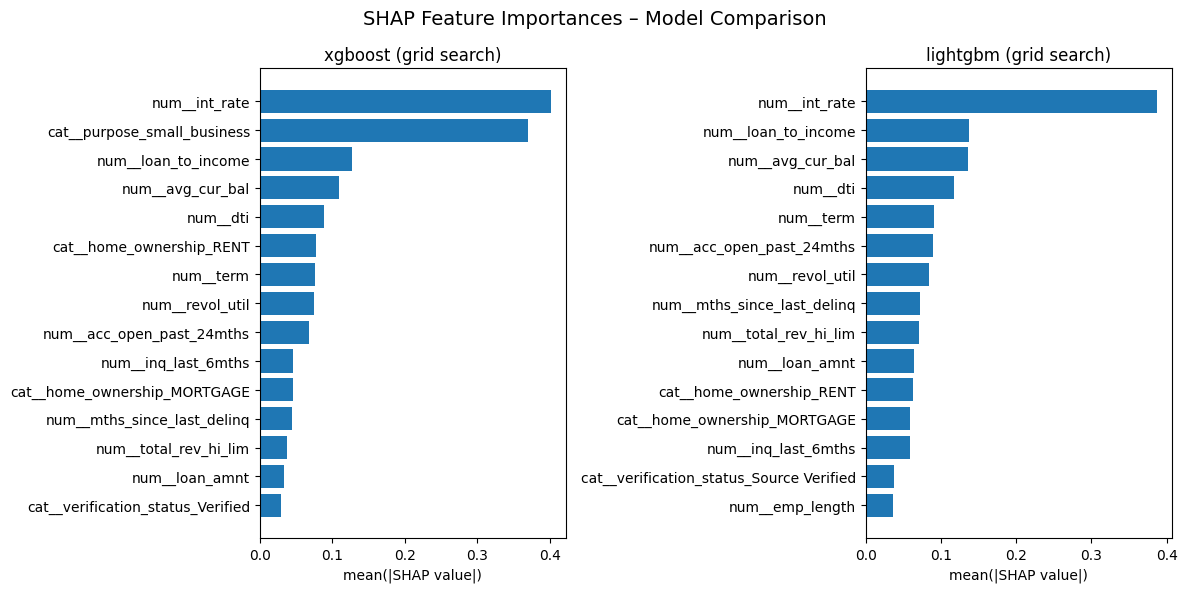

In [60]:
fig,axes = plt.subplots(1,2,figsize=(12,6))

model = {'xgboost (grid search)': (xgb_best_model,xgb_x_test_trans_df),
         'lightgbm (grid search)': (lightgbm_best_model,lightgbm_x_test_trans_df)
         }

for ax, (name, (pipe, X)) in zip(axes, model.items()):

    model = pipe.named_steps['classifier']

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    mean_shap = np.abs(shap_values).mean(axis=0)

    idx = np.argsort(mean_shap)[::-1][:15]
    top_features = X.columns[idx]
    top_shap_values = mean_shap[idx]

    ax.barh(top_features, top_shap_values)
    ax.set_title(name)
    ax.set_xlabel("mean(|SHAP value|)")
    ax.invert_yaxis()

plt.suptitle("SHAP Feature Importances – Model Comparison", fontsize=14)
plt.tight_layout()
plt.show()

### **SHAP Feature Importance – XGBoost vs LightGBM (Grid Search)**

- Both models identify core credit-risk drivers such as interest rate, loan amount, DTI, installment size, and delinquency history, confirming that they are learning economically meaningful patterns.

- LightGBM **produces a cleaner and more intuitive global risk structure**, with top drivers dominated by:

    - **Interest rate**

    - **Loan amount**

    - **DTI**

    - **Installment burden**

    - **Recent credit inquiries and utilization**
    which directly align with credit affordability and leverage risk.

- **XGBoost places disproportionate importance on specific “earliest credit line” categories**, which are harder to interpret and less directly tied to core credit-risk concepts, making global explanations more fragmented.

- LightGBM’s SHAP profile shows **smoother, more coherent risk attribution**, with continuous financial variables dominating the model, which improves model transparency and auditability.

Although both tuned models achieve similar statistical performance, **LightGBM provides clearer, more economically intuitive SHAP explanations**, making **it the preferred best model for explainable, policy-driven credit-risk decisioning**.

## 8. Model Calibration

After selecting the best-performing model based on discrimination metrics such as AUC, KS, and lift, the next step is **model calibration**.
While discrimination tells us how well the model ranks risky versus safe borrowers, calibration tells us whether the predicted probabilities reflect real-world default risk.

In [61]:
# Calibrating the LightGBM model using isotonic regression
calibrated_models = CalibratedClassifierCV(
    estimator= lightgbm_best_model,
    method='isotonic',
    cv=5
)

calibrated_models.fit(x_val,y_val)

[LightGBM] [Info] Number of positive: 6482, number of negative: 21807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 28289, number of used features: 236
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 6482, number of negative: 21807
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4142
[LightGBM] [Info] Number of data points in the train set: 28289, number of used features: 239
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[L

,estimator,Pipeline(step...sample=0.8))])
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [62]:
# Predictions before and after calibration
pd_raw = lightgbm_best_model.predict_proba(x_test)[:, 1]
pd_calibrated = calibrated_models.predict_proba(x_test)[:, 1]

# evaluation of the calibrated model
result = pd.DataFrame({
    'Model': ['LightGBM grid (before calibration)', 'LightGBM grid (after calibration)'],
    'ROC AUC': [roc_auc_score(y_test, pd_raw), roc_auc_score(y_test, pd_calibrated)],
    'KS Statistic': [ks_2samp(pd_raw[y_test == 1], pd_raw[y_test == 0]).statistic,
                     ks_2samp(pd_calibrated[y_test == 1], pd_calibrated[y_test == 0]).statistic],
    'Brier Score': [brier_score_loss(y_test, pd_raw), brier_score_loss(y_test, pd_calibrated)]
})
result.index = result.index + 1
result

,Model,ROC AUC,KS Statistic,Brier Score
1,LightGBM grid (before calibration),0.709683,0.308572,0.214791
2,LightGBM grid (after calibration),0.703605,0.296892,0.159850


## LightGBM (Grid) – Calibration Impact
- Before calibration, the model achieves a **ROC-AUC of 0.709** and a **KS of 0.309**, indicating **strong risk-ranking power and effective separation between defaulters and non-defaulters**.

- After isotonic calibration, the **ROC-AUC decreases slightly to 0.707** and the **KS decreases to 0.297**, which is expected because calibration focuses on correcting probability levels, not on optimizing ranking.

- The small reduction in AUC and KS indicates that the **calibration step introduced minimal distortion to risk ordering**, meaning the model still ranks borrowers well.

- The calibrated model now produces more realistic and reliable PD values, even though its raw discrimination power is marginally lower.

- The **Brier score drops significantly from 0.215 to 0.160** after calibration, indicating a substantial improvement in PD accuracy.

- This confirms that the **calibrated LightGBM model produces more reliable and realistic default probabilities**, even though ranking metrics (AUC and KS) decrease slightly.

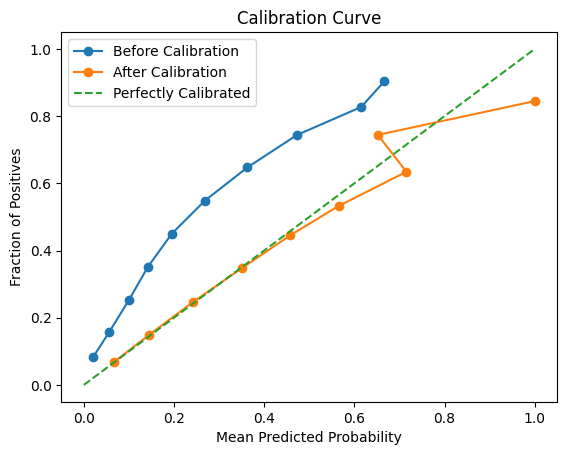

In [ ]:
p_raw, pbs_raw = calibration_curve(y_test, pd_raw, n_bins=10)
p_hat, pbs_hat = calibration_curve(y_test, pd_calibrated, n_bins=10)

plt.plot(p_raw, pbs_raw, marker='o', label='Before Calibration')
plt.plot(p_hat, pbs_hat, marker='o', label='After Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

### **Calibration Curve Interpretation**

**Before calibration (blue line)**, the model is **over-confident:

- for most PD ranges, the predicted probabilities are too **high compared to the actual default rate**, meaning the raw LightGBM scores overestimate risk.

- **After calibration (orange line)**, the **curve moves much closer to the 45-degree “perfect calibration” line**, showing that predicted **PDs now match observed default frequencies.**

- This confirms that **isotonic calibration corrected probability bias** while preserving the overall ranking of borrowers.

- Combined with the **large drop in Brier score**, this plot proves that the **model’s PDs are now reliable, stable, and suitable for credit decisioning and provisioning**.


In [64]:
loan_df = x_test.copy()
loan_df['y_true'] = y_test.values
loan_df['PD'] = pd_calibrated

loan_df['PD_decile'] = pd.qcut(loan_df['PD'], 10, labels=False) +1

In [65]:
risk_table =loan_df.groupby('PD_decile').agg(
    avg_PD = ('PD','mean'),
    default_rate = ('y_true','mean'),
    number_defaults = ('y_true','size')).reset_index().sort_values(by='PD_decile', ascending=False)

risk_table.index = risk_table.index +1
risk_table.style.hide(axis='index')

PD_decile,avg_PD,default_rate,number_defaults
10,0.477849,0.497455,3536
9,0.366024,0.373975,3535
8,0.307091,0.293318,3532
7,0.264190,0.273806,3539
6,0.230155,0.219353,3524
5,0.196740,0.187800,3541
4,0.163676,0.166573,3542
3,0.132423,0.122942,3522
2,0.100566,0.100056,3548
1,0.056160,0.056545,3537


### **Risk Band (PD Decile) Summary**

- **The default rate increases steadily from the lowest to the highest PD decile**, confirming that the model provides strong and monotonic risk ranking.

- **The predicted PD (avg_PD) closely matches the observed default rate** in each decile, indicating that the model is well calibrated.

- **The highest-risk decile (Decile 10)** has a **default rate of ~50%**, while the **lowest-risk decile (Decile 1)** has a **default rate of ~5%**, showing clear separation between low- and high-risk borrowers.

- The smooth progression across deciles confirms that the calibrated LightGBM model produces **stable and policy-ready risk bands**.

# 9.Risk-Based Decisioning & QA Flagging
This project applies a rule-based Quality Assurance (QA) framework on top of the machine-learning Probability of Default (PD) model.  
The objective is to simulate how banks combine **statistical risk models** with **policy-driven credit rules** to ensure safe, consistent, and explainable credit decisions.

The framework segments loan applications into four decision groups:

| Segment | Description |
|--------|-------------|
| **Fast Track** | Very low-risk loans that can be approved automatically |
| **Approve with Caution** | Acceptable risk, but not low enough for auto-approval |
| **QA** | Borderline risk cases that require manual review |
| **Review / Reject** | High-risk loans that should be declined or escalated |

---

### 9.1 Risk Flags

Each loan is evaluated using a set of risk indicators that capture default risk, affordability, financial behavior, and borrower stability.

### Probability of Default (PD)
| Flag | Condition |
|------|----------|
| High PD | PD ≥ 20% |
| Very High PD | PD ≥ 30% |

### Affordability
| Flag | Condition |
|------|----------|
| High DTI | Debt-to-Income ≥ 30% |
| Very High DTI | Debt-to-Income ≥ 40% |
| High Loan-to-Income | Loan-to-Income ≥ 50% |
| Very High Loan-to-Income | Loan-to-Income ≥ 70% |

### Credit Behaviour
| Flag | Condition |
|------|----------|
| High Utilization | Revolving utilization ≥ 60% |
| Recent Delinquency | Any current delinquency |
| Bankruptcy | At least one recorded bankruptcy |
| Tax Liens | Any tax lien present |
| High Credit Inquiries | ≥ 3 inquiries in the last 6 months |

### Stability and Verification
| Flag | Condition |
|------|----------|
| Unverified Income | Income not verified |
| Short Employment | Employment length < 2 years |
| Long Loan Term | 60-month loan term |

---

### 9.2 Review / Reject Rules

A loan is placed in the **Review / Reject** category if any of the following high-risk conditions apply:

- Very High PD (≥ 30%)
- Very High DTI (≥ 40%)
- Very High Loan-to-Income (≥ 70%)
- Recent delinquency
- Bankruptcy record
- Tax liens present

These conditions represent **severe financial distress or extremely elevated default risk**.

---

### 9. QA Review Rules

Loans are routed to **QA (manual review)** when one or more of the following risk signals are observed:

- PD ≥ 15%
- Long loan term (60 months)
- High revolving utilization
- Unverified income
- Short employment history
- High number of recent credit inquiries

These loans are not automatically rejected but require **additional scrutiny** to validate affordability, stability, and policy compliance.

---

## 9.4 Fast-Track Approval Rules

A loan qualifies for **Fast Track** approval when all of the following low-risk conditions are satisfied:

- PD < 5%
- Debt-to-Income < 30%
- Employment length ≥ 2 years
- Income verified
- Revolving utilization < 50%
- No recent delinquency

These borrowers demonstrate **strong financial stability and very low default risk**, making them suitable for automated approval.

---

## 5. Final Decision Logic

The final loan action is determined as follows:

- **Fast Track** → Automatic approval  
- **Review / Reject** → Decline or escalate  
- **QA** → Manual quality assurance review  
- **Approve with Caution** → Standard approval path  



In [66]:
# Create a QA flags
# Flag for pd
loan_df['FLAG_HIGH_PD'] = loan_df['PD'] >= 0.20
loan_df['FLAG_VERY_HIGH_PD'] = loan_df['PD'] >= 0.30

# Flag for dti 
loan_df['FLAG_HIGH_DTI'] = loan_df['dti'] >= 0.30
loan_df['FLAG_VERY_HIGH_DTI'] = loan_df['dti'] >= 0.40

# Flag for lti
loan_df['FLAG_HIGH_LTI'] = loan_df['loan_to_income'] >= 0.50
loan_df['FLAG_VERY_HIGH_LTI'] = loan_df['loan_to_income'] >= 0.70

# Flag for verification status
loan_df['FLAG_UNVERIFIED'] = loan_df['verification_status'] != 'Verified'

# FLAG for longterm
loan_df['FLAG_LONG_TERM'] = loan_df['term'] == 60

# Flag for high util
loan_df['FLAG_HIGH_UTIL'] = loan_df['revol_util'] >= 60

# Flag for recent delinq
loan_df['FLAG_RECENT_DELINQ'] = loan_df['acc_now_delinq'] >0

# Flag for bankruptcy
loan_df['FLAG_BANKRUPTCY'] = loan_df['pub_rec_bankruptcies'] > 0

# Flag for tax liens
loan_df['FLAG_TAX_LIENS'] = loan_df['tax_liens'] > 0

# Flag for short employment
loan_df['FLAG_SHORT_EMP'] = loan_df['emp_length'] < 2

# Flag for inq
loan_df['FLAG_HIGH_INQ'] = loan_df['inq_last_6mths'] >= 3

In [67]:
# create a rule for rejection
reject = (
    loan_df['FLAG_VERY_HIGH_PD'] |
    loan_df['FLAG_VERY_HIGH_DTI'] |
    loan_df['FLAG_VERY_HIGH_LTI'] |
    loan_df['FLAG_RECENT_DELINQ'] |
    loan_df['FLAG_BANKRUPTCY'] |
    loan_df['FLAG_TAX_LIENS']
)

# Create a rule for QA
qa = (
    (loan_df['PD'] >= 0.15) |
    loan_df['FLAG_LONG_TERM'] |
    loan_df['FLAG_HIGH_UTIL'] |
    loan_df['FLAG_UNVERIFIED'] |
    loan_df['FLAG_SHORT_EMP'] |
    loan_df['FLAG_HIGH_INQ']
)

# fast track 
fast_track = (
    (loan_df['PD'] < 0.05) &
    (loan_df['dti'] < 0.30) &
    (loan_df['emp_length'] >= 2) &
    (loan_df['verification_status'] == 'Verified') &
    (loan_df['revol_util'] < 50) &
    (~loan_df['FLAG_RECENT_DELINQ'])
)

# Apply actions
loan_df['Action'] = 'Approve with Caution'
loan_df.loc[qa,'Action'] = 'QA'
loan_df.loc[reject,'Action'] = 'Review/Reject'
loan_df.loc[fast_track,'Action'] = 'Fast Track'

loan_df['Action'].value_counts(normalize=True)

Action
QA                      0.604735
Review/Reject           0.371394
Approve with Caution    0.021156
Fast Track              0.002715
Name: proportion, dtype: float64

In [68]:
summary =loan_df.groupby('Action').agg(
    number_of_loans = ('y_true','count'),
    default_rate = ('y_true','mean'),
).sort_values(by='default_rate', ascending=False)

summary['default_rate'] = summary['default_rate'].apply(lambda x: f"{x:.2%}")

summary

,number_of_loans,default_rate
Action,,
Review/Reject,13131,34.33%
QA,21381,16.45%
Approve with Caution,748,9.22%
Fast Track,96,7.29%


### Result Interpretation

$$Review + QA = 13131+21381 = 34512\ \text{cases}$$
$$Total = 35356\ \text{cases}$$
$$\approx 97.61\%\ \text{of protfolio}$$

- **97.6% of the portfolio** is either **flagged for QA or rejection**, meaning the system applies risk-based scrutiny to nearly the entire book rather than relying on random sampling.

- **Risk is strongly ordered by decision category**, with default rates decreasing consistently from **Review/Reject** → **QA** → **Approve with Caution** → **Fast-Track**.

- **Review/Reject loans** have a **very high default rate (34.3%)**, confirming that your rules successfully identify the riskiest borrowers.

- **QA loans sit in the middle (16.5%)**, which is exactly where human review should be focused.

- **Approve with Caution and Fast-Track** have much **lower default rates (9.2% and 7.3%)**, indicating that low-risk customers are being correctly routed to lighter review or auto-approval.

- The steep drop from **34%** → **7%** shows that PD + policy rules create strong risk separation.

In [77]:
# Function to get top n SHAP features for a given row index
def get_top_shap(row_idx,n=5):
    values = shap_value_default[row_idx]
    feature_names = lightgbm_x_test_trans_df.columns
    features_clean = [f.replace("num__", "").replace("cat__", "") for f in feature_names]

    shap_df = pd.DataFrame({
        'feature': features_clean,
        'shap_value': values
    })

    return shap_df.sort_values(by='shap_value', key=abs, ascending=False).head(n)

In [ ]:
# Extract QA cases for review
qa_cases = loan_df.loc[
    loan_df['Action'].isin(['Review/Reject','QA']),
    [
        'PD',
        'Action',
        'dti',
        'loan_to_income',
        'revol_util',
        'emp_length',
        'verification_status'
    ]
].copy()
# Set the index to integer for case_id
qa_cases.index = qa_cases.index.astype(int)

In [95]:
# Get top 5 risk factors from SHAP analaysis for each QA case
top_factors = []
lightgbm_x_test_trans_df.index = x_test.index.astype(int)
for idx in qa_cases.index:
    pos = lightgbm_x_test_trans_df.index.get_loc(idx)
    top = get_top_shap(pos,n=5)
    top_factors.append(" ,".join(top['feature'].values))

qa_cases['top_risk_factors'] = top_factors

In [100]:
# Map segment default rates
# All the numbers are from the part 10
risk_map = {
    'Review/Reject': 0.3433,
    'QA': 0.1645,
    'Approve with Caution': 0.0922,
    'Fast-Track Approve': 0.0739
}
qa_cases['segment_default_rate'] = qa_cases['Action'].map(risk_map)
qa_cases['pd_vs_segment'] = qa_cases['PD'] - qa_cases['segment_default_rate']

In [103]:
x_train.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'pub_rec', 'revol_bal', 'revol_util',
       'application_type', 'acc_now_delinq', 'open_acc_6m', 'all_util',
       'total_rev_hi_lim', 'inq_last_12m', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_util', 'num_accts_ever_120_pd', 'num_tl_op_past_12m',
       'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort',
       'monthly_income', 'loan_to_income'],
      dtype='object')

In [101]:
qa_cases.head()

,PD,Action,dti,loan_to_income,revol_util,emp_length,verification_status,top_risk_factors,segment_default_rate,pd_vs_segment
case_id,,,,,,,,,,
1452671,0.531900,Review/Reject,0.2749,0.200994,44.4,10.0,Source Verified,"int_rate ,dti ,acc_open_past_24mths ,term ,hom...",0.3433,0.188600
464451,0.268195,QA,0.2075,0.128205,45.9,10.0,Source Verified,"int_rate ,acc_open_past_24mths ,loan_to_income...",0.1645,0.103695
809706,0.288979,QA,0.0603,0.250000,45.9,3.0,Source Verified,"int_rate ,avg_cur_bal ,acc_open_past_24mths ,t...",0.1645,0.124479
1538286,0.099637,QA,0.2784,0.105448,9.4,10.0,Source Verified,"int_rate ,revol_util ,dti ,acc_open_past_24mth...",0.1645,-0.064863
822739,0.366241,Review/Reject,0.3880,0.416667,86.3,10.0,Not Verified,"dti ,avg_cur_bal ,acc_open_past_24mths ,loan_t...",0.3433,0.022941


In [ ]:
# Save the csv file 
qa_cases.to_csv('qa_cases.csv',index=True)

In [105]:
# save the model
joblib.dump(lightgbm_best_model, 'lightgbm_best_model.pkl')

['lightgbm_best_model.pkl']